# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import subprocess
from IPython.display import display, Markdown, HTML
import os

suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [3]:
from data_processing import load_data

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 26 Nov 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "40-49": 10,
        "30-39": 11,
        "18-29": 12,                
        "16-17": 0 
        # NB if the population denominator is not included for the final group (0), the key must contain phrase "not in other eligible groups" so that data is presented appropriately
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "housebound", "chronic_cardiac_disease", "current_copd", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "ckd"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "housebound")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer", "housebound"
                                      )]
# under50s
u50 = ["sex", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    u50, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD", "ckd"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "40-49":    u50,
                 "30-39":    u50,
                 "18-29":    u50,
                 "16-17":    ["sex", "ethnicity_6_groups", "imd_categories"],
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

In [12]:
# for details on second/third doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

df_dict_cum_third_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_third_dose_date")

### Cumulative vaccination figures - overall

In [13]:
from report_results import make_vaccine_graphs

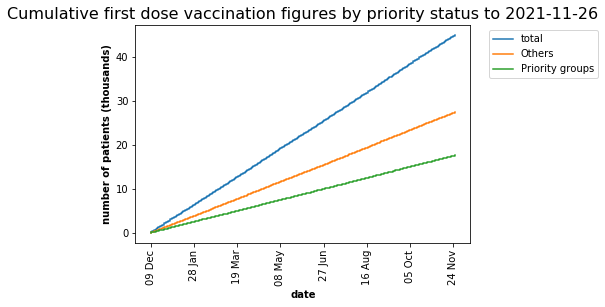

In [14]:
make_vaccine_graphs(df, latest_date=latest_date, grouping="priority_status", savepath_figure_csvs=savepath_figure_csvs, savepath=savepath, suffix=suffix)

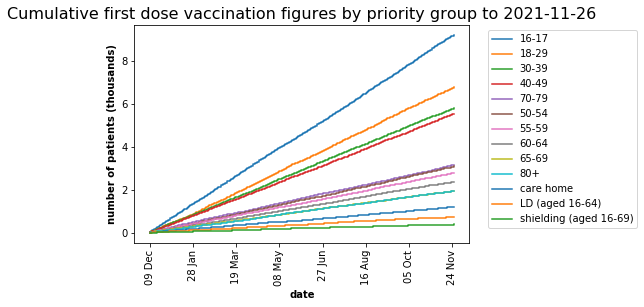

In [15]:
make_vaccine_graphs(df, latest_date=latest_date, include_total=False, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [16]:
from report_results import summarise_data_by_group

In [17]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

In [18]:
summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

summarised_data_dict_3rd_dose = summarise_data_by_group(df_dict_cum_third_dose, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [19]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [20]:
summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [21]:
summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

summ_stat_results_3rd_dose, _ = create_summary_stats(df, summarised_data_dict_3rd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="third_dose", suffix=suffix)

In [22]:
# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)).join(pd.DataFrame(summ_stat_results_3rd_dose)))   
display(Markdown(f"*\n figures rounded to nearest 7"))

,first dose as at 08 Nov 2021,second dose as at 08 Nov 2021,third dose as at 08 Nov 2021
Total vaccinated in TPP,"45,003","39,998","4,998"
80+,"90.1% (1,911 of 2,121)","79.9% (1,694 of 2,121)","9.6% (203 of 2,121)"
70-79,"90.1% (3,115 of 3,458)","80.6% (2,786 of 3,458)","10.1% (350 of 3,458)"
care home,"88.3% (1,218 of 1,379)","78.7% (1,085 of 1,379)","10.7% (147 of 1,379)"
shielding (aged 16-69),88.7% (385 of 434),79.0% (343 of 434),11.3% (49 of 434)
65-69,"88.9% (1,911 of 2,149)","79.8% (1,715 of 2,149)","9.8% (210 of 2,149)"
LD (aged 16-64),90.4% (728 of 805),79.1% (637 of 805),10.4% (84 of 805)
60-64,"90.5% (2,534 of 2,800)","79.5% (2,226 of 2,800)","9.8% (273 of 2,800)"
55-59,"89.6% (2,821 of 3,150)","79.1% (2,492 of 3,150)","9.6% (301 of 3,150)"
50-54,"90.0% (3,087 of 3,430)","79.8% (2,737 of 3,430)","9.2% (315 of 3,430)"


*
 figures rounded to nearest 7

In [23]:
# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

Oxford-AZ vaccines (% of all first doses): **0.1%** (49)

Pfizer vaccines (% of all first doses): **0.2%** (77)

Moderna vaccines (% of all first doses): **0.1%** (35)

Second doses (% of all vaccinated): **88.9%** (39,998)

Second doses (% of Ox-AZ first doses): **5342.9%** (2,618)

Second doses (% of Pfizer first doses): **1663.6%** (1,281)

Second doses (% of Moderna first doses): **8840.0%** (3,094)

Mixed doses Ox-AZ + Pfizer (% of fully vaccinated): **0.0%** (0)

Mixed doses Ox-AZ + Moderna (% of fully vaccinated): **0.0%** (0)

Mixed doses Moderna + Pfizer (% of fully vaccinated): **0.0%** (0)

*
 figures rounded to nearest 7

# Detailed summary of coverage among population groups as at latest date

In [24]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)

## 

## COVID vaccination rollout (first dose) among **80+** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1911   
sex                       F                                           987   
                          M                                           924   
ageband_5yr               0                                            21   
                          0-15                                        133   
                          16-17                                       112   
                          18-29                                       140   
                          30-34                                       126   
                          35-39                                       133   
                          40-44                                       133   
                          45-49                                       133   
                          50-54                                        98   
                          55-59                                       147   
                          60-64                                        98   
                          65-69                                       119   
                          70-74                                       119   
                          75-79                                       126   
                          80-84                                       119   
                          85-89                                       119   
                          90+                                          28   
ethnicity_6_groups        Black                                       315   
                          Mixed                                       308   
                          Other                                       315   
                          South Asian                                 357   
                          Unknown                                     266   
                          White                                       343   
ethnicity_16_groups        African                                     91   
                           Bangladeshi or British Bangladeshi          91   
                           Caribbean                                   84   
                           Chinese                                    105   
                           Other                                       91   
                           Other Asian                                112   
                          British or Mixed British                    112   
                          Indian or British Indian                    105   
                          Irish                                       105   
                          Other Black                                 105   
                          Other White                                  84   
                          Other mixed                                 105   
                          Pakistani or British Pakistani               91   
                          Unknown                                     301   
                          White + Asian                               105   
                          White + Black African                       126   
                          White + Black Caribbean                      98   
imd_categories            1 Most deprived                             364   
                          2                                           357   
                          3                                           392   
                          4                                           357   
                          5 Least deprived                            350   
                          Unknown                                      91   
bmi                       30+                                         595   
                          under 30                         

## 

## COVID vaccination rollout (first dose) among **70-79** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    3115   
sex                       F                                          1582   
                          M                                          1533   
ageband_5yr               0                                            49   
                          0-15                                        210   
                          16-17                                       210   
                          18-29                                       217   
                          30-34                                       182   
                          35-39                                       203   
                          40-44                                       203   
                          45-49                                       203   
                          50-54                                       203   
                          55-59                                       203   
                          60-64                                       210   
                          65-69                                       175   
                          70-74                                       210   
                          75-79                                       210   
                          80-84                                       203   
                          85-89                                       189   
                          90+                                          35   
ethnicity_6_groups        Black                                       532   
                          Mixed                                       497   
                          Other                                       532   
                          South Asian                                 504   
                          Unknown                                     504   
                          White                                       539   
ethnicity_16_groups        African                                    189   
                           Bangladeshi or British Bangladeshi         154   
                           Caribbean                                  161   
                           Chinese                                    161   
                           Other                                      168   
                           Other Asian                                147   
                          British or Mixed British                    154   
                          Indian or British Indian                    189   
                          Irish                                       161   
                          Other Black                                 147   
                          Other White                                 182   
                          Other mixed                                 168   
                          Pakistani or British Pakistani              168   
                          Unknown                                     476   
                          White + Asian                               154   
                          White + Black African                       168   
                          White + Black Caribbean                     182   
imd_categories            1 Most deprived                             588   
                          2                                           595   
                          3                                           616   
                          4                                           595   
                          5 Least deprived                            567   
                          Unknown                                     154   
bmi                       30+                                         945   
                          under 30                         

## 

## COVID vaccination rollout (first dose) among **care home** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall            1218     88.3   1379   
sex                F                   623     89.0    700   
                   M                   595     87.6    679   
ageband_5yr        0                    14    100.0     14   
                   0-15                 91     92.9     98   
                   16-17                84     92.3     91   
                   18-29                91     86.7    105   
                   30-34                70     83.3     84   
                   35-39                98     87.5    112   
                   40-44                77     91.7     84   
                   45-49                70     83.3     84   
                   50-54                84     92.3     91   
                   55-59                77     91.7     84   
                   60-64                77     84.6     91   
                   65-69                70     90.9     77   
                   70-74                91     81.2    112   
                   75-79                70     90.9     77   
                   80-84                70     90.9     77   
                   85-89                70    100.0     70   
                   90+                  14    100.0     14   
ethnicity_6_groups Black               217     88.6    245   
                   Mixed               210     88.2    238   
                   Other               217     93.9    231   
                   South Asian         196     90.3    217   
                   Unknown             189     87.1    217   
                   White               196     87.5    224   
dementia           no                 1211     88.3   1372   
                   yes                   7    100.0      7   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 86.8   
sex                F                                         88   
                   M                                       85.6   
ageband_5yr        0                                        100   
                   0-15                                    92.9   
                   16-17                                   92.3   
                   18-29                                   86.7   
                   30-34                                   83.3   
                   35-39                                   87.5   
                   40-44                                   91.7   
                   45-49                                   83.3   
                   50-54                                   84.6   
                   55-59                                   83.3   
                   60-64                                   84.6   
                   65-69                                   90.9   
                   70-74                                   81.2   
                   75-79                                   90.9   
                   80-84                                   90.9   
                   85-89                                    100   
                   90+                                      100   
ethnicity_6_groups Black                                   85.7   
                   Mixed                                   88.2   
                   Other                                   90.9   
                   South Asian                             90.3   
                   Unknown                                 83.9   
                   White                                   84.4   
dementia           no                                      86.7   
                   yes                                      100   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

## 

## COVID vaccination rollout (first dose) among **shielding (aged 16-69)** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  385     88.7    434   
newly_shielded_since_feb_15 no                       385     88.7    434   
                            yes                        0      0.0      0   
sex                         F                        196     87.5    224   
                            M                        189     90.0    210   
ageband                     16-29                     49     77.8     63   
                            30-39                     56     88.9     63   
                            40-49                     56     80.0     70   
                            50-59                     49    100.0     49   
                            60-69                     42    100.0     42   
                            70-79                     98     93.3    105   
                            80+                       42    100.0     42   
ethnicity_6_groups          Black                     63     81.8     77   
                            Mixed                     70    100.0     70   
                            Other                     77     91.7     84   
                            South Asian               70     90.9     77   
                            Unknown                   42     75.0     56   
                            White                     56     80.0     70   
imd_categories              1 Most deprived           70     83.3     84   
                            2                         84    100.0     84   
                            3                         49     87.5     56   
                            4                         70     90.9     77   
                            5 Least deprived          91     92.9     98   
                            Unknown                   21     75.0     28   
LD                          no                       378     88.5    427   
                            yes                        0      0.0      0   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      85.5   
newly_shielded_since_feb_15 no                                           85.5   
                            yes                                           NaN   
sex                         F                                            84.4   
                            M                                            86.7   
ageband                     16-29                                        77.8   
                            30-39                                        88.9   
                            40-49                                          80   
                            50-59                                        85.7   
                            60-69                                         100   
                            70-79                                        86.7   
                            80+                                           100   
ethnicity_6_groups          Black                                        81.8   
                            Mixed                                          90   
                            Other                                        91.7   
                            South Asian                                  90.9   
                            Unknown                                        75   
                            White                                          80   
imd_categories              1 Most deprived                              83.3   
                            2                                            91.7   
                            3                                            87.5   
                            4                         

## 

## COVID vaccination rollout (first dose) among **65-69** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1911   
sex                       F                                           973   
                          M                                           938   
ethnicity_6_groups        Black                                       350   
                          Mixed                                       322   
                          Other                                       315   
                          South Asian                                 336   
                          Unknown                                     245   
                          White                                       350   
ethnicity_16_groups        African                                     91   
                           Bangladeshi or British Bangladeshi          98   
                           Caribbean                                  112   
                           Chinese                                    105   
                           Other                                      112   
                           Other Asian                                105   
                          British or Mixed British                     91   
                          Indian or British Indian                     91   
                          Irish                                       105   
                          Other Black                                 119   
                          Other White                                 105   
                          Other mixed                                  98   
                          Pakistani or British Pakistani              112   
                          Unknown                                     266   
                          White + Asian                                98   
                          White + Black African                       112   
                          White + Black Caribbean                      91   
imd_categories            1 Most deprived                             385   
                          2                                           371   
                          3                                           343   
                          4                                           357   
                          5 Least deprived                            364   
                          Unknown                                      91   
bmi                       30+                                         595   
                          under 30                                   1316   
housebound                no                                         1897   
                          yes                                          14   
chronic_cardiac_disease   no                                         1897   
                          yes                                          14   
current_copd              no                                         1890   
                          yes                                          21   
dmards                    no                                         1897   
                          yes                                          14   
dementia                  no                                         1890   
                          yes                                          21   
psychosis_schiz_bipolar   no                                         1897   
                          yes                                          14   
LD                        no                                         1869   
                          yes                                          42   
ssri                      no                                         1890   
                          yes                                          21   
chemo_or_radio            no                               

## 

## COVID vaccination rollout (first dose) among **LD (aged 16-64)** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             728     90.4    805   
sex                F                   392     91.8    427   
                   M                   336     90.6    371   
ageband_5yr        0                    21    100.0     21   
                   0-15                 49     87.5     56   
                   16-17                56     88.9     63   
                   18-29                49     87.5     56   
                   30-34                42     85.7     49   
                   35-39                49     87.5     56   
                   40-44                49    100.0     49   
                   45-49                49    100.0     49   
                   50-54                42     85.7     49   
                   55-59                42    100.0     42   
                   60-64                42     85.7     49   
                   65-69                49     87.5     56   
                   70-74                28     80.0     35   
                   75-79                49    100.0     49   
                   80-84                63     90.0     70   
                   85-89                35     83.3     42   
                   90+                   7     50.0     14   
ethnicity_6_groups Black               119     89.5    133   
                   Mixed               140     90.9    154   
                   Other               119     89.5    133   
                   South Asian         119     89.5    133   
                   Unknown             112     94.1    119   
                   White               119     89.5    133   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 87.8   
sex                F                                       90.2   
                   M                                       88.7   
ageband_5yr        0                                        100   
                   0-15                                    87.5   
                   16-17                                   88.9   
                   18-29                                   87.5   
                   30-34                                   85.7   
                   35-39                                   87.5   
                   40-44                                   85.7   
                   45-49                                    100   
                   50-54                                   85.7   
                   55-59                                    100   
                   60-64                                   85.7   
                   65-69                                   87.5   
                   70-74                                     80   
                   75-79                                   85.7   
                   80-84                                     80   
                   85-89                                   83.3   
                   90+                                       50   
ethnicity_6_groups Black                                   84.2   
                   Mixed                                   86.4   
                   Other                                   89.5   
                   South Asian                             89.5   
                   Unknown                                 94.1   
                   White                                   84.2   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               2.6   
sex                F                                     1.6   
                   M                                     1.9   
ageband_5yr        0                                       0   
                   0-15           

## 

## COVID vaccination rollout (first dose) among **60-64** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2534   
sex                       F                                          1337   
                          M                                          1204   
ethnicity_6_groups        Black                                       427   
                          Mixed                                       420   
                          Other                                       434   
                          South Asian                                 406   
                          Unknown                                     399   
                          White                                       441   
ethnicity_16_groups        African                                    133   
                           Bangladeshi or British Bangladeshi         140   
                           Caribbean                                  140   
                           Chinese                                    119   
                           Other                                      133   
                           Other Asian                                140   
                          British or Mixed British                    154   
                          Indian or British Indian                    140   
                          Irish                                       119   
                          Other Black                                 126   
                          Other White                                 147   
                          Other mixed                                 133   
                          Pakistani or British Pakistani              133   
                          Unknown                                     378   
                          White + Asian                               133   
                          White + Black African                       126   
                          White + Black Caribbean                     133   
imd_categories            1 Most deprived                             504   
                          2                                           476   
                          3                                           469   
                          4                                           462   
                          5 Least deprived                            490   
                          Unknown                                     133   
bmi                       30+                                         784   
                          under 30                                   1750   
chronic_cardiac_disease   no                                         2513   
                          yes                                          21   
current_copd              no                                         2506   
                          yes                                          35   
dmards                    no                                         2513   
                          yes                                          28   
dementia                  no                                         2513   
                          yes                                          21   
psychosis_schiz_bipolar   no                                         2513   
                          yes                                          21   
ssri                      no                                         2513   
                          yes                                          28   
chemo_or_radio            no                                         2513   
                          yes                                          28   
lung_cancer               no                                         2513   
                          yes                                          21   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose) among **55-59** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    2821   
sex                     F                                          1428   
                        M                                          1400   
ethnicity_6_groups      Black                                       490   
                        Mixed                                       469   
                        Other                                       455   
                        South Asian                                 483   
                        Unknown                                     420   
                        White                                       511   
ethnicity_16_groups      African                                    126   
                         Bangladeshi or British Bangladeshi         154   
                         Caribbean                                  161   
                         Chinese                                    161   
                         Other                                      154   
                         Other Asian                                140   
                        British or Mixed British                    140   
                        Indian or British Indian                    147   
                        Irish                                       154   
                        Other Black                                 168   
                        Other White                                 140   
                        Other mixed                                 147   
                        Pakistani or British Pakistani              175   
                        Unknown                                     406   
                        White + Asian                               147   
                        White + Black African                       175   
                        White + Black Caribbean                     133   
imd_categories          1 Most deprived                             525   
                        2                                           539   
                        3                                           574   
                        4                                           525   
                        5 Least deprived                            525   
                        Unknown                                     140   
bmi                     30+                                         819   
                        under 30                                   2009   
chronic_cardiac_disease no                                         2800   
                        yes                                          21   
current_copd            no                                         2800   
                        yes                                          28   
dmards                  no                                         2793   
                        yes                                          28   
psychosis_schiz_bipolar no                                         2800   
                        yes                                          21   
ssri                    no                                         2800   
                        yes                                          21   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 89.6   3150   
sex                     F                                       90.3   1582   
                        M                                       89.3   1568   
ethnicity_6_groups      Black                                   89.7    546   
                        Mixed                                   89.3    525   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **50-54** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    3087   
sex                     F                                          1561   
                        M                                          1526   
ethnicity_6_groups      Black                                       539   
                        Mixed                                       532   
                        Other                                       532   
                        South Asian                                 497   
                        Unknown                                     462   
                        White                                       525   
ethnicity_16_groups      African                                    161   
                         Bangladeshi or British Bangladeshi         154   
                         Caribbean                                  168   
                         Chinese                                    182   
                         Other                                      168   
                         Other Asian                                161   
                        British or Mixed British                    147   
                        Indian or British Indian                    147   
                        Irish                                       154   
                        Other Black                                 154   
                        Other White                                 182   
                        Other mixed                                 161   
                        Pakistani or British Pakistani              161   
                        Unknown                                     462   
                        White + Asian                               175   
                        White + Black African                       175   
                        White + Black Caribbean                     168   
imd_categories          1 Most deprived                             616   
                        2                                           560   
                        3                                           623   
                        4                                           602   
                        5 Least deprived                            546   
                        Unknown                                     147   
bmi                     30+                                         917   
                        under 30                                   2170   
chronic_cardiac_disease no                                         3059   
                        yes                                          28   
current_copd            no                                         3052   
                        yes                                          35   
dmards                  no                                         3045   
                        yes                                          42   
psychosis_schiz_bipolar no                                         3066   
                        yes                                          28   
ssri                    no                                         3059   
                        yes                                          28   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 90.0   3430   
sex                     F                                       89.9   1736   
                        M                                       90.1   1694   
ethnicity_6_groups      Black                                   91.7    588   
                        Mixed                                   90.5    588   
                        Other                            

## 

## COVID vaccination rollout (first dose) among **40-49** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    5446     89.4   
sex                 F                                          2779     89.0   
                    M                                          2667     89.9   
ethnicity_6_groups  Black                                       959     90.1   
                    Mixed                                       896     88.9   
                    Other                                       945     88.8   
                    South Asian                                 924     91.0   
                    Unknown                                     798     90.5   
                    White                                       931     88.7   
ethnicity_16_groups  African                                    294     89.4   
                     Bangladeshi or British Bangladeshi         287     87.2   
                     Caribbean                                  266     88.4   
                     Chinese                                    294     87.5   
                     Other                                      280     87.0   
                     Other Asian                                266     88.4   
                    British or Mixed British                    266     88.4   
                    Indian or British Indian                    308     88.0   
                    Irish                                       287     89.1   
                    Other Black                                 280     88.9   
                    Other White                                 287     89.1   
                    Other mixed                                 301     91.5   
                    Pakistani or British Pakistani              308     88.0   
                    Unknown                                     847     91.0   
                    White + Asian                               287     89.1   
                    White + Black African                       287     91.1   
                    White + Black Caribbean                     287     89.1   
imd_categories      1 Most deprived                            1064     88.9   
                    2                                          1015     89.5   
                    3                                          1001     88.3   
                    4                                          1050     90.4   
                    5 Least deprived                           1078     90.1   
                    Unknown                                     245     89.7   

                                                         total  \
category            group                                        
overall             overall                               6090   
sex                 F                                     3122   
                    M                                     2968   
ethnicity_6_groups  Black                                 1064   
                    Mixed                                 1008   
                    Other                                 1064   
                    South Asian                           1015   
                    Unknown                                882   
                    White                                 1050   
ethnicity_16_groups  African                               329   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             301   
                     Chinese                               336   
                     Other                                 322   
                     Other Asian                           301   
                    British or Mixed British               301   
                    Indian or British Indian               350   
                    Irish                                  322   
                

## 

## COVID vaccination rollout (first dose) among **30-39** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    5754     90.5   
sex                 F                                          2940     90.1   
                    M                                          2814     91.0   
ethnicity_6_groups  Black                                       952     91.9   
                    Mixed                                      1029     90.7   
                    Other                                       952     89.5   
                    South Asian                                 980     90.3   
                    Unknown                                     875     91.2   
                    White                                       973     90.8   
ethnicity_16_groups  African                                    315     90.0   
                     Bangladeshi or British Bangladeshi         287     91.1   
                     Caribbean                                  287     89.1   
                     Chinese                                    315     90.0   
                     Other                                      301     89.6   
                     Other Asian                                273     90.7   
                    British or Mixed British                    287     87.2   
                    Indian or British Indian                    301     91.5   
                    Irish                                       294     89.4   
                    Other Black                                 287     91.1   
                    Other White                                 343     92.5   
                    Other mixed                                 301     93.5   
                    Pakistani or British Pakistani              357     92.7   
                    Unknown                                     910     90.9   
                    White + Asian                               308     91.7   
                    White + Black African                       287     89.1   
                    White + Black Caribbean                     308     88.0   
imd_categories      1 Most deprived                            1106     90.8   
                    2                                          1120     90.4   
                    3                                          1071     90.5   
                    4                                          1127     91.0   
                    5 Least deprived                           1057     91.0   
                    Unknown                                     273     90.7   

                                                         total  \
category            group                                        
overall             overall                               6356   
sex                 F                                     3262   
                    M                                     3094   
ethnicity_6_groups  Black                                 1036   
                    Mixed                                 1134   
                    Other                                 1064   
                    South Asian                           1085   
                    Unknown                                959   
                    White                                 1071   
ethnicity_16_groups  African                               350   
                     Bangladeshi or British Bangladeshi    315   
                     Caribbean                             322   
                     Chinese                               350   
                     Other                                 336   
                     Other Asian                           301   
                    British or Mixed British               329   
                    Indian or British Indian               329   
                    Irish                                  329   
                

## 

## COVID vaccination rollout (first dose) among **18-29** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    6720     90.5   
sex                 F                                          3451     90.8   
                    M                                          3269     90.2   
ethnicity_6_groups  Black                                      1127     91.0   
                    Mixed                                      1197     91.4   
                    Other                                      1099     89.7   
                    South Asian                                1120     90.4   
                    Unknown                                    1001     88.3   
                    White                                      1169     90.8   
ethnicity_16_groups  African                                    336     88.9   
                     Bangladeshi or British Bangladeshi         357     89.5   
                     Caribbean                                  371     89.8   
                     Chinese                                    336     87.3   
                     Other                                      350     92.6   
                     Other Asian                                364     91.2   
                    British or Mixed British                    357     89.5   
                    Indian or British Indian                    357     89.5   
                    Irish                                       357     89.5   
                    Other Black                                 343     92.5   
                    Other White                                 385     91.7   
                    Other mixed                                 364     89.7   
                    Pakistani or British Pakistani              371     93.0   
                    Unknown                                     987     90.4   
                    White + Asian                               364     89.7   
                    White + Black African                       350     90.9   
                    White + Black Caribbean                     364     89.7   
imd_categories      1 Most deprived                            1260     90.9   
                    2                                          1323     90.0   
                    3                                          1239     90.3   
                    4                                          1267     91.0   
                    5 Least deprived                           1281     89.7   
                    Unknown                                     343     90.7   

                                                         total  \
category            group                                        
overall             overall                               7427   
sex                 F                                     3801   
                    M                                     3626   
ethnicity_6_groups  Black                                 1239   
                    Mixed                                 1309   
                    Other                                 1225   
                    South Asian                           1239   
                    Unknown                               1134   
                    White                                 1288   
ethnicity_16_groups  African                               378   
                     Bangladeshi or British Bangladeshi    399   
                     Caribbean                             413   
                     Chinese                               385   
                     Other                                 378   
                     Other Asian                           399   
                    British or Mixed British               399   
                    Indian or British Indian               399   
                    Irish                                  399   
                

## 

## COVID vaccination rollout (first dose) among **16-17** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                          
overall            overall                 9366     90.0  10409   
sex                F                       4739     90.3   5250   
                   M                       4627     89.7   5159   
ethnicity_6_groups Black                   1582     90.0   1757   
                   Mixed                   1631     89.6   1820   
                   Other                   1582     89.3   1771   
                   South Asian             1596     90.8   1757   
                   Unknown                 1386     89.6   1547   
                   White                   1596     90.5   1764   
imd_categories     1 Most deprived         1834     90.0   2037   
                   2                       1792     89.8   1995   
                   3                       1729     89.5   1932   
                   4                       1813     90.2   2009   
                   5 Least deprived        1715     90.1   1904   
                   Unknown                  483     90.8    532   

                                    vaccinated 7d previous (percent)  \
category           group                                               
overall            overall                                      88.2   
sex                F                                            88.1   
                   M                                            88.1   
ethnicity_6_groups Black                                          88   
                   Mixed                                        87.7   
                   Other                                        87.7   
                   South Asian                                  89.2   
                   Unknown                                      87.8   
                   White                                        87.7   
imd_categories     1 Most deprived                              88.3   
                   2                                            88.4   
                   3                                            87.3   
                   4                                            88.5   
                   5 Least deprived                             87.9   
                   Unknown                                      88.2   

                                    Uptake over last 7d (percent)  \
category           group                                            
overall            overall                                    1.8   
sex                F                                          2.2   
                   M                                          1.6   
ethnicity_6_groups Black                                        2   
                   Mixed                                      1.9   
                   Other                                      1.6   
                   South Asian                                1.6   
                   Unknown                                    1.8   
                   White                                      2.8   
imd_categories     1 Most deprived                            1.7   
                   2                                          1.4   
                   3                                          2.2   
                   4                                          1.7   
                   5 Least deprived                           2.2   
                   Unknown                                    2.6   

                                    Date projected to reach 90%  
category           group                                         
overall            overall                              reached  
sex                F                                    reached  
                   M                                     09-Nov  
ethnicity_6_groups Black                                reached  
                   Mixed                                 09-Nov  
                   Other            

# Demographics time trend charts

In [25]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 08 Nov 2021

### COVID vaccinations among **80+** population by **sex**

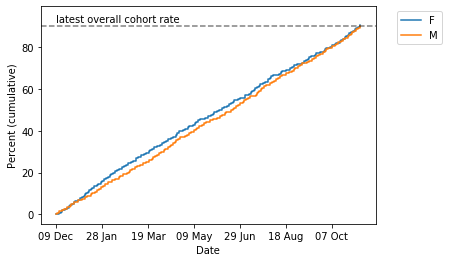

### COVID vaccinations among **80+** population by **ageband 5yr**

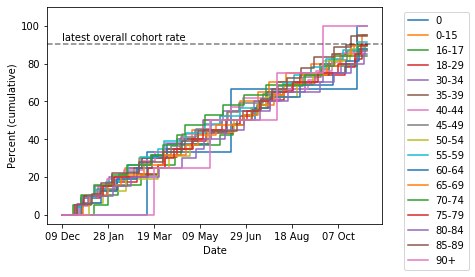

### COVID vaccinations among **80+** population by **ethnicity 6 groups**

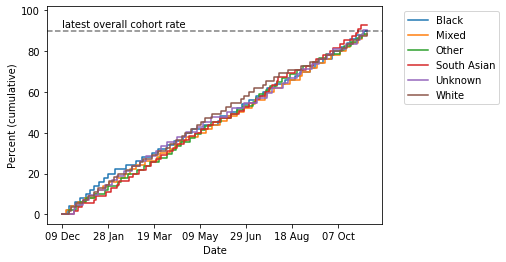

### COVID vaccinations among **80+** population by **imd categories**

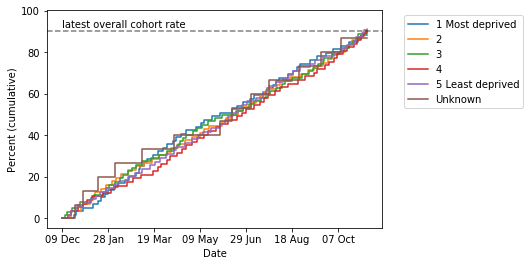

### COVID vaccinations among **80+** population by **bmi**

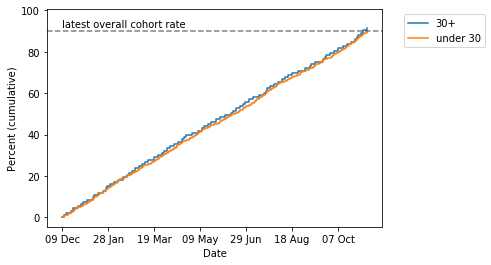

### COVID vaccinations among **80+** population by **housebound**

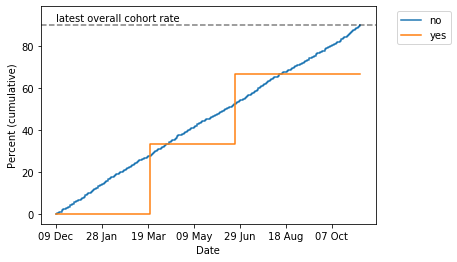

### COVID vaccinations among **80+** population by **dialysis**

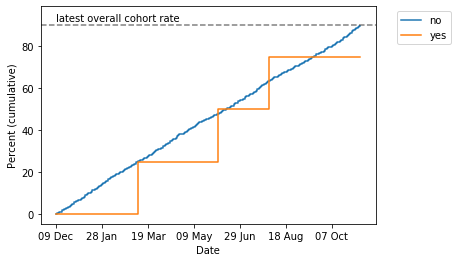

### COVID vaccinations among **80+** population by **dementia**

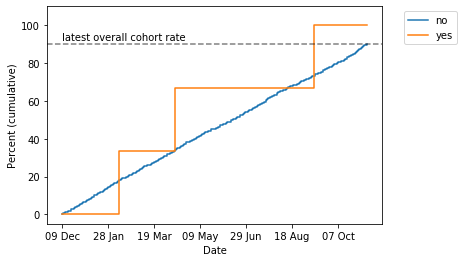

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

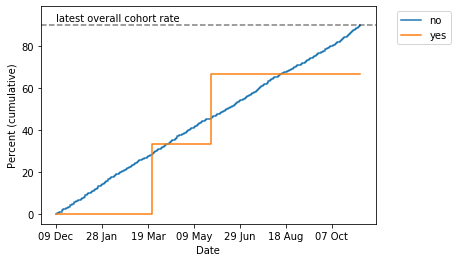

### COVID vaccinations among **80+** population by **LD**

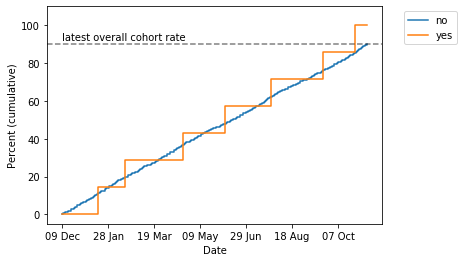

### COVID vaccinations among **80+** population by **ssri**

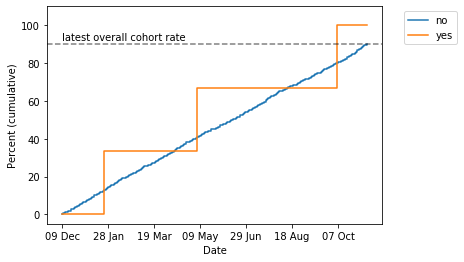

## 
 ## COVID vaccination rollout among **70-79** population up to 08 Nov 2021

### COVID vaccinations among **70-79** population by **sex**

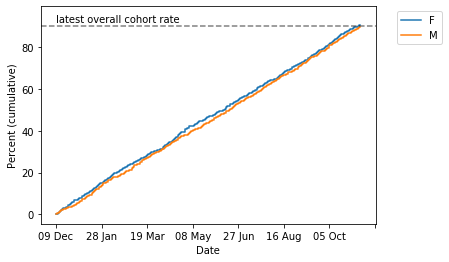

### COVID vaccinations among **70-79** population by **ageband 5yr**

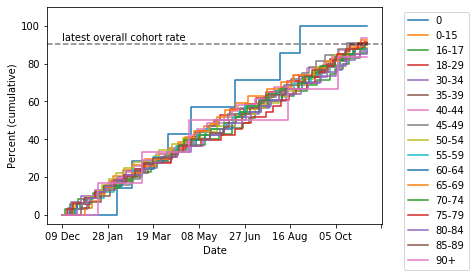

### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

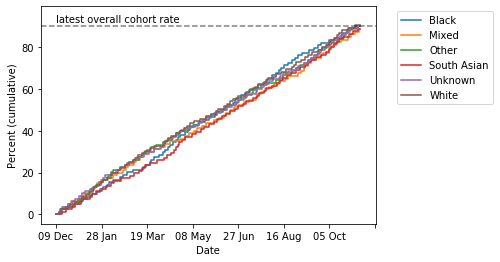

### COVID vaccinations among **70-79** population by **imd categories**

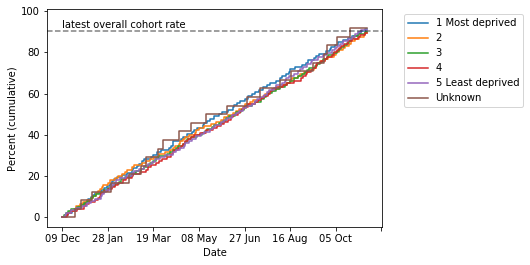

### COVID vaccinations among **70-79** population by **bmi**

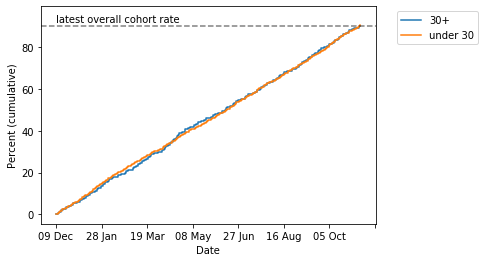

### COVID vaccinations among **70-79** population by **housebound**

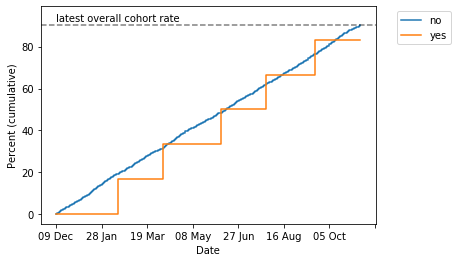

### COVID vaccinations among **70-79** population by **dialysis**

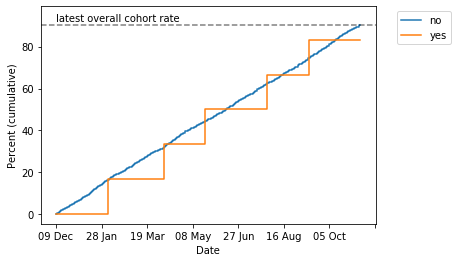

### COVID vaccinations among **70-79** population by **dementia**

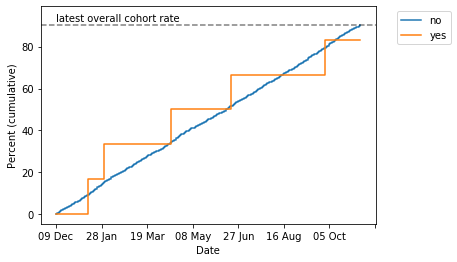

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

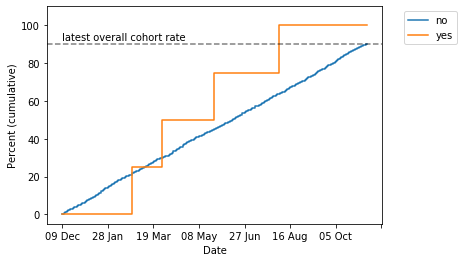

### COVID vaccinations among **70-79** population by **LD**

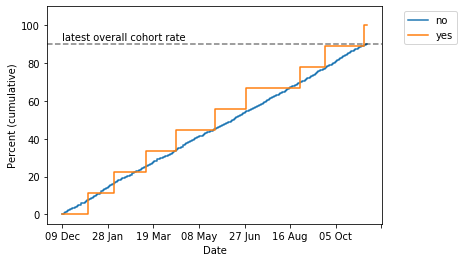

### COVID vaccinations among **70-79** population by **ssri**

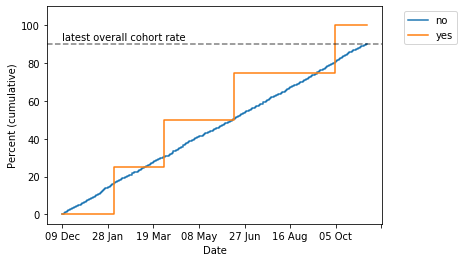

## 
 ## COVID vaccination rollout among **65-69** population up to 08 Nov 2021

### COVID vaccinations among **65-69** population by **sex**

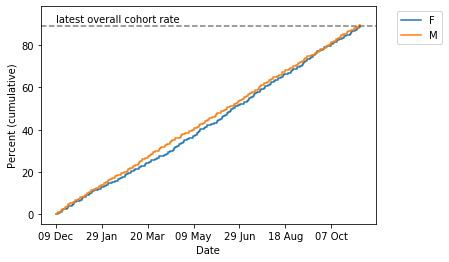

### COVID vaccinations among **65-69** population by **ethnicity 6 groups**

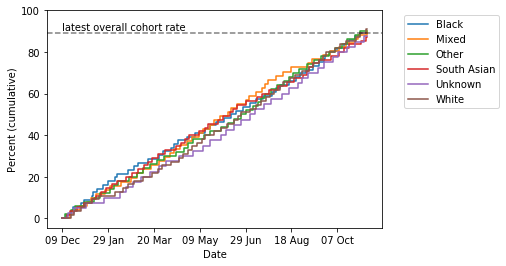

### COVID vaccinations among **65-69** population by **imd categories**

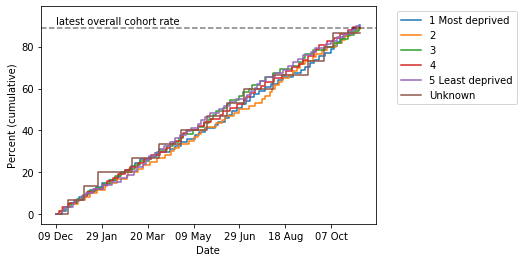

### COVID vaccinations among **65-69** population by **bmi**

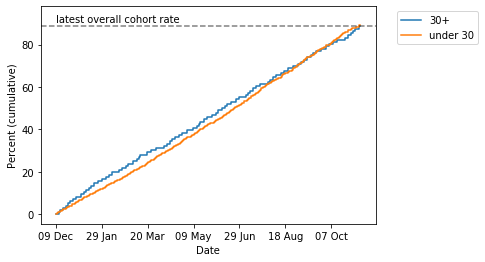

### COVID vaccinations among **65-69** population by **housebound**

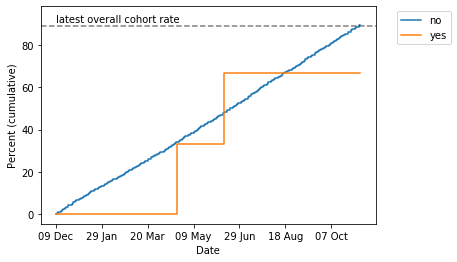

### COVID vaccinations among **65-69** population by **dementia**

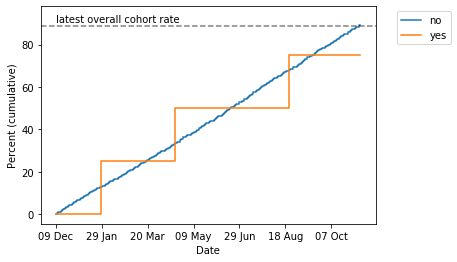

### COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

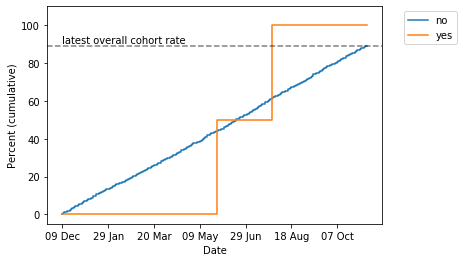

### COVID vaccinations among **65-69** population by **LD**

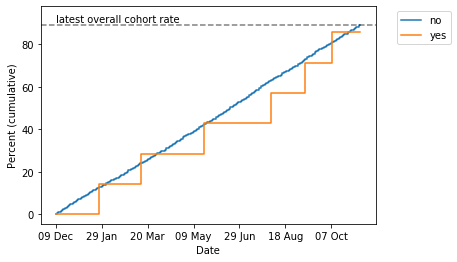

### COVID vaccinations among **65-69** population by **ssri**

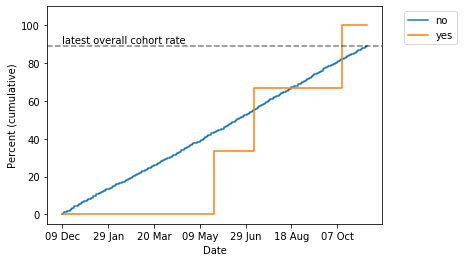

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 08 Nov 2021

### COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

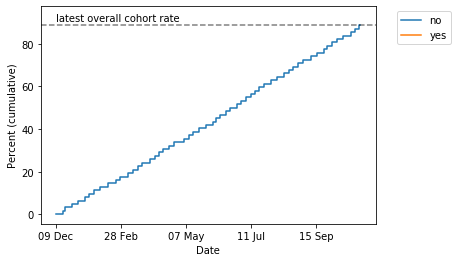

### COVID vaccinations among **shielding (aged 16-69)** population by **sex**

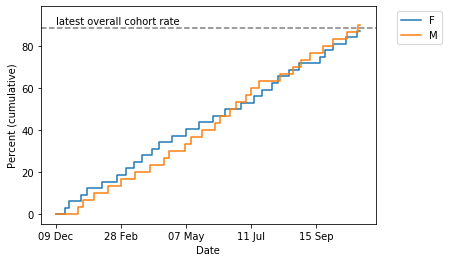

### COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

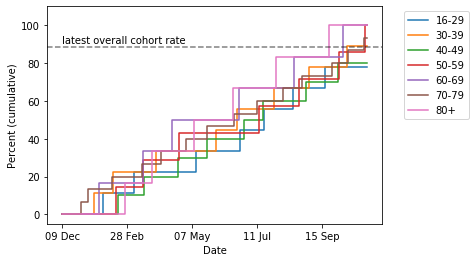

### COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

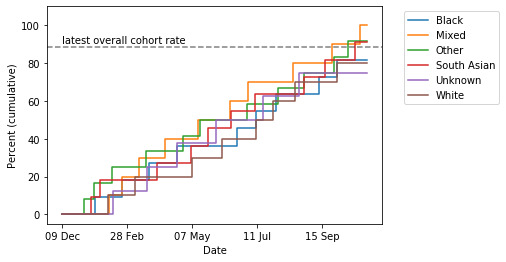

### COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

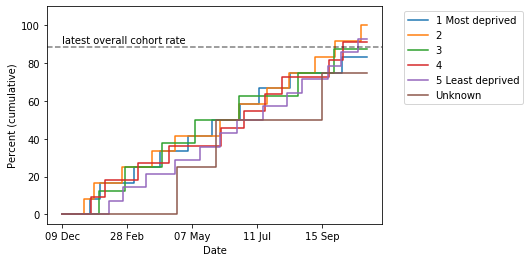

### COVID vaccinations among **shielding (aged 16-69)** population by **LD**

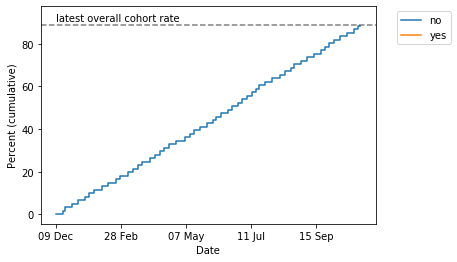

## 
 ## COVID vaccination rollout among **60-64** population up to 08 Nov 2021

### COVID vaccinations among **60-64** population by **sex**

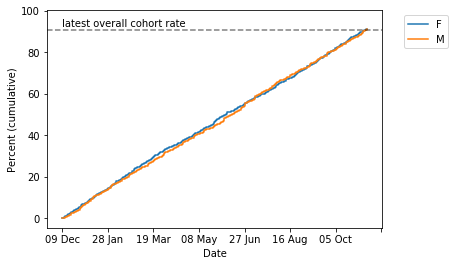

### COVID vaccinations among **60-64** population by **ethnicity 6 groups**

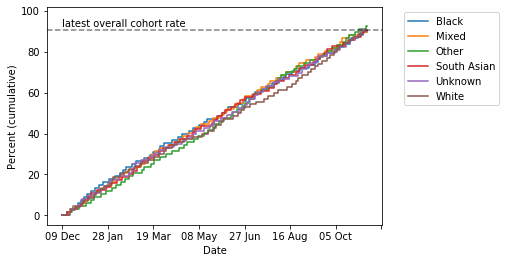

### COVID vaccinations among **60-64** population by **imd categories**

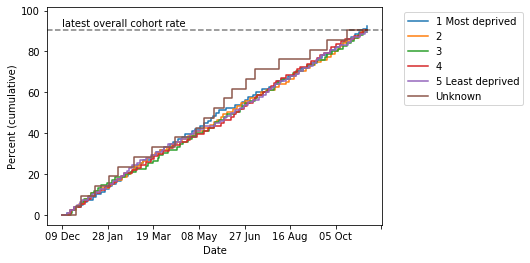

### COVID vaccinations among **60-64** population by **bmi**

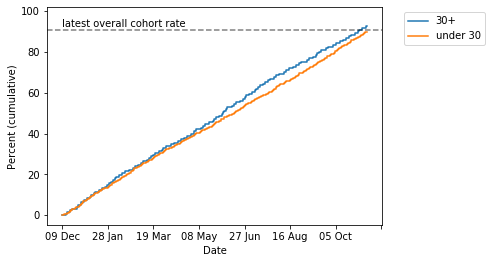

### COVID vaccinations among **60-64** population by **dementia**

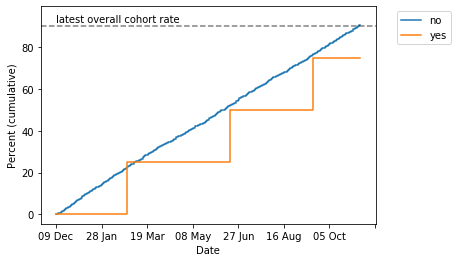

### COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

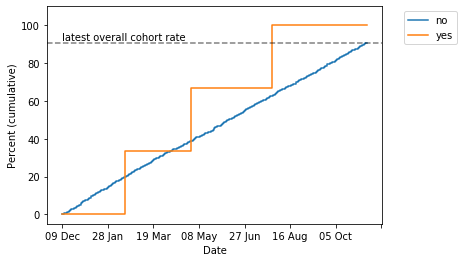

### COVID vaccinations among **60-64** population by **ssri**

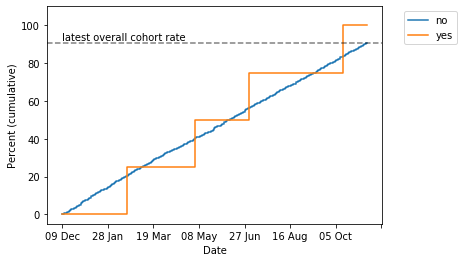

## 
 ## COVID vaccination rollout among **55-59** population up to 08 Nov 2021

### COVID vaccinations among **55-59** population by **sex**

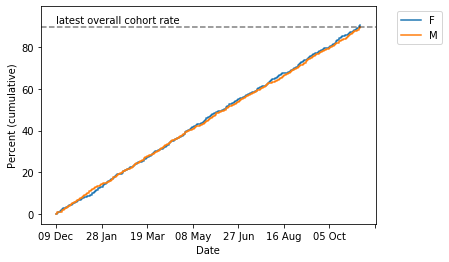

### COVID vaccinations among **55-59** population by **ethnicity 6 groups**

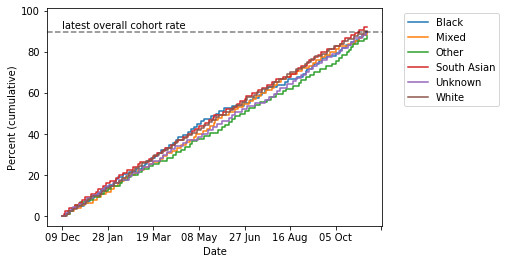

### COVID vaccinations among **55-59** population by **imd categories**

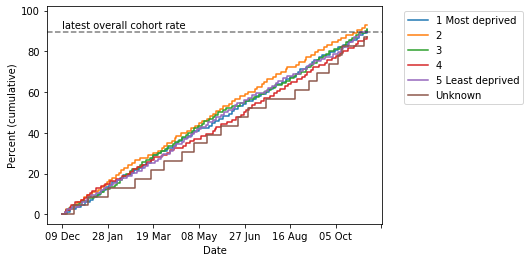

### COVID vaccinations among **55-59** population by **bmi**

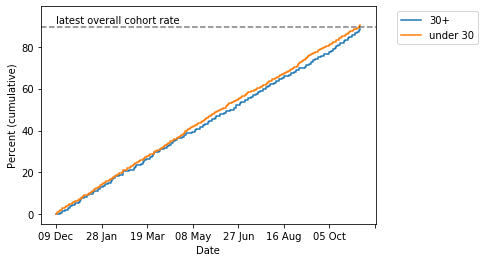

### COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

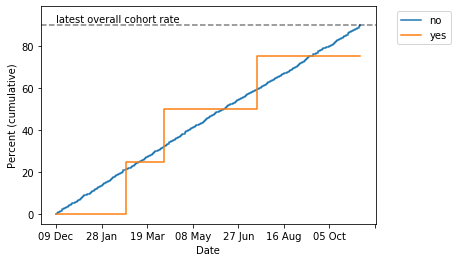

### COVID vaccinations among **55-59** population by **ssri**

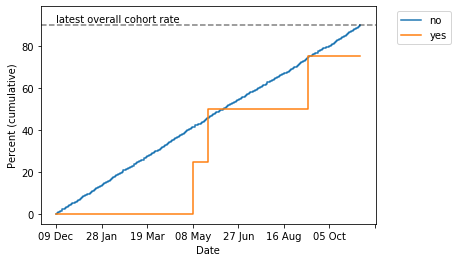

## 
 ## COVID vaccination rollout among **50-54** population up to 08 Nov 2021

### COVID vaccinations among **50-54** population by **sex**

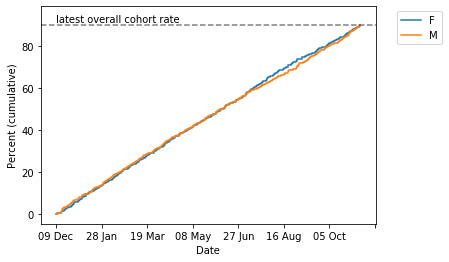

### COVID vaccinations among **50-54** population by **ethnicity 6 groups**

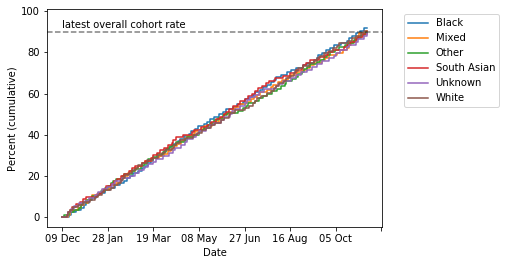

### COVID vaccinations among **50-54** population by **imd categories**

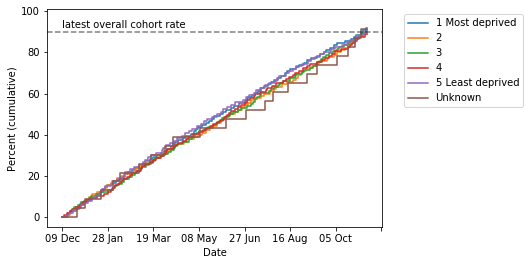

### COVID vaccinations among **50-54** population by **bmi**

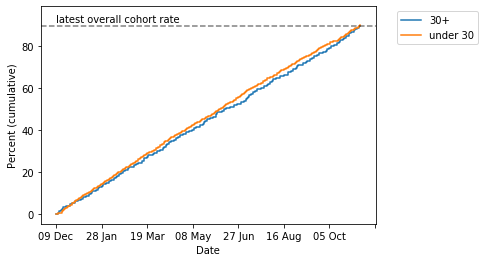

### COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

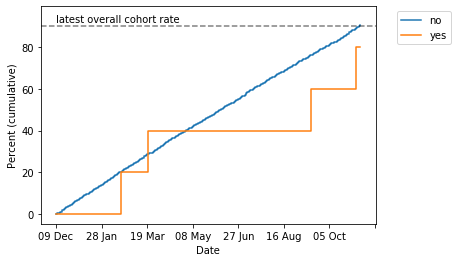

### COVID vaccinations among **50-54** population by **ssri**

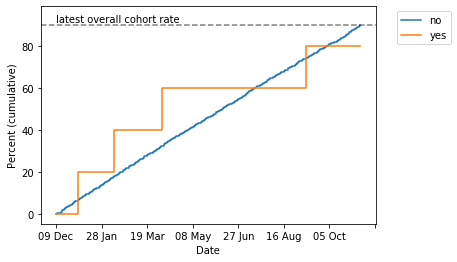

## 
 ## COVID vaccination rollout among **40-49** population up to 08 Nov 2021

### COVID vaccinations among **40-49** population by **sex**

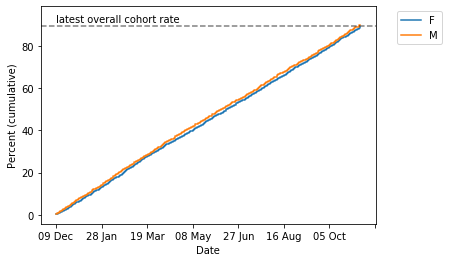

### COVID vaccinations among **40-49** population by **ethnicity 6 groups**

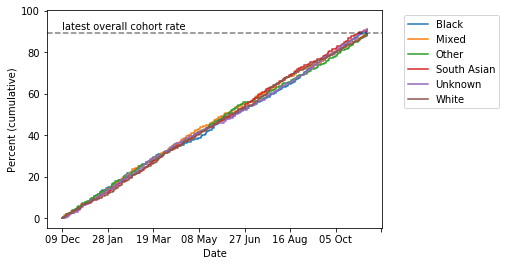

### COVID vaccinations among **40-49** population by **imd categories**

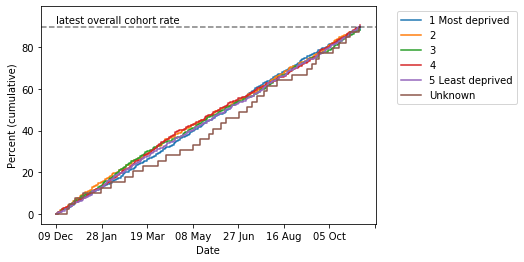

## 
 ## COVID vaccination rollout among **30-39** population up to 08 Nov 2021

### COVID vaccinations among **30-39** population by **sex**

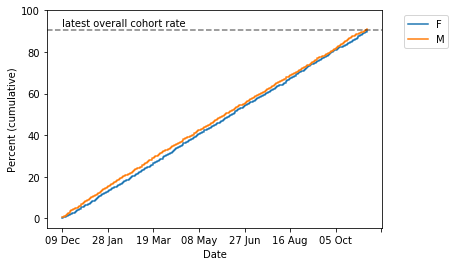

### COVID vaccinations among **30-39** population by **ethnicity 6 groups**

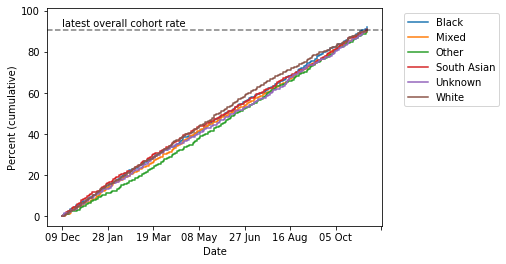

### COVID vaccinations among **30-39** population by **imd categories**

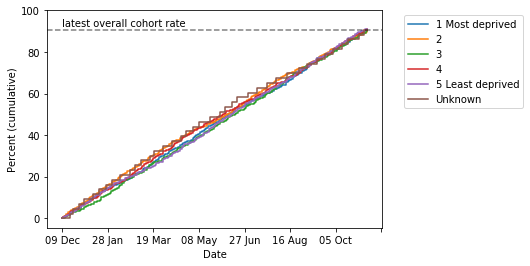

## 
 ## COVID vaccination rollout among **18-29** population up to 08 Nov 2021

### COVID vaccinations among **18-29** population by **sex**

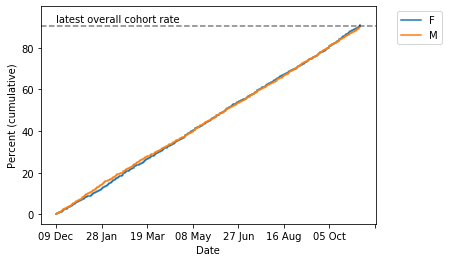

### COVID vaccinations among **18-29** population by **ethnicity 6 groups**

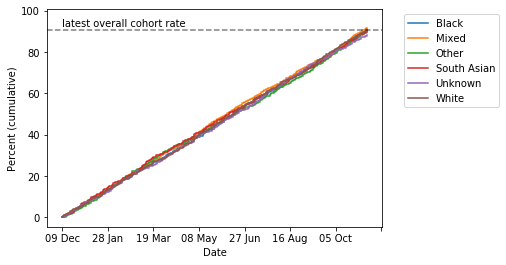

### COVID vaccinations among **18-29** population by **imd categories**

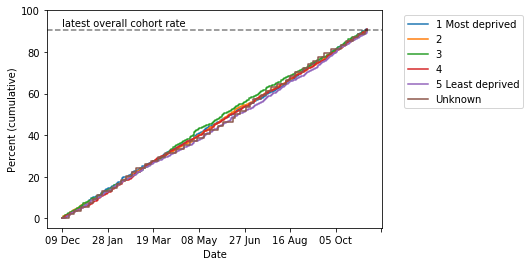

In [26]:
plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54", "40-49", "30-39", "18-29"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "current_copd", "chronic_cardiac_disease", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [27]:
from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


Total **80+** population with ethnicity recorded 1,820 (85.8%)

Total **70-79** population with ethnicity recorded 2,898 (83.8%)

Total **care home** population with ethnicity recorded 1,162 (84.3%)

Total **shielding (aged 16-69)** population with ethnicity recorded 378 (87.1%)

Total **65-69** population with ethnicity recorded 1,869 (87.0%)

Total **LD (aged 16-64)** population with ethnicity recorded 679 (84.3%)

Total **60-64** population with ethnicity recorded 2,352 (84.0%)

Total **55-59** population with ethnicity recorded 2,681 (85.1%)

Total **50-54** population with ethnicity recorded 2,912 (84.9%)

Total **40-49** population with ethnicity recorded 5,208 (85.5%)

Total **30-39** population with ethnicity recorded 5,397 (84.9%)

Total **18-29** population with ethnicity recorded 6,300 (84.8%)

Total **16-17** population with ethnicity recorded 8,869 (85.2%)

# Second doses

In [28]:
# only count second doses where the first dose was given at least 14 weeks ago 
# to allow comparison of the first dose situation 14w ago with the second dose situation now
# otherwise bias could be introduced from any second doses given early in certain subgroups

def subtract_from_date(s, unit, number, description):
    '''
    s (series): a series of date-like strings
    unit (str) : days/weeks
    number (int): number of days/weeks to subtract
    description (str): description of new date calculated to use as filename
    '''
    if unit == "weeks":
        new_date = pd.to_datetime(s).max() - timedelta(weeks=number)
    elif unit == "days":
        new_date = pd.to_datetime(s).max() - timedelta(days=number)
    else:
        display("invalid unit")
        return
    new_date = str(new_date)[:10]

    formatted_date = datetime.strptime(new_date, "%Y-%m-%d").strftime("%d %b %Y")
    with open(os.path.join(savepath["text"], f"{description}.txt"), "w") as text_file:
            text_file.write(formatted_date)
    
    display(Markdown(formatted_date))
    return new_date, formatted_date    
    

date_14w, formatted_date_14w = subtract_from_date(s=df["covid_vacc_date"], unit="weeks", number=14, 
                                             description="latest_date_of_first_dose_for_due_second_doses")

02 Aug 2021

In [29]:
# filter data
df_s = df.copy()
# replace any second doses not yet "due" with "0"
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) >= date_14w), "covid_vacc_second_dose_date"] = 0

# also ensure that first dose was dated after the start of the campaign, otherwise date is likely incorrect 
# and due date for second dose cannot be calculated accurately
# this also excludes any second doses where first dose date = 0 (this should affect dummy data only!)
df_s.loc[(pd.to_datetime(df_s["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_second_dose_date"] = 0

In [30]:
# add "brand of first dose" to list of features to break down by
import copy
features_dict_2 = copy.deepcopy(features_dict)

for k in features_dict_2:
    ls = list(features_dict_2[k])
    ls.append("brand_of_first_dose") 
    features_dict_2[k] = ls

In [31]:
# data processing / summarising
df_dict_cum_second_dose = cumulative_sums(df_s, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

second_dose_summarised_data_dict = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

create_detailed_summary_uptake(second_dose_summarised_data_dict, formatted_latest_date, 
                               groups=groups,
                               savepath=savepath, vaccine_type="second_dose")

# ## For comparison look at first doses UP TO 14 WEEKS AGO
#

## 

## COVID vaccination rollout (second dose) among **80+** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1071   
sex                       F                                           560   
                          M                                           511   
ageband_5yr               0                                             7   
                          0-15                                         77   
                          16-17                                        70   
                          18-29                                        77   
                          30-34                                        70   
                          35-39                                        77   
                          40-44                                        70   
                          45-49                                        84   
                          50-54                                        56   
                          55-59                                        91   
                          60-64                                        49   
                          65-69                                        70   
                          70-74                                        70   
                          75-79                                        70   
                          80-84                                        70   
                          85-89                                        56   
                          90+                                          14   
ethnicity_6_groups        Black                                       175   
                          Mixed                                       175   
                          Other                                       168   
                          South Asian                                 203   
                          Unknown                                     147   
                          White                                       203   
ethnicity_16_groups        African                                     56   
                           Bangladeshi or British Bangladeshi          49   
                           Caribbean                                   49   
                           Chinese                                     56   
                           Other                                       42   
                           Other Asian                                 70   
                          British or Mixed British                     63   
                          Indian or British Indian                     63   
                          Irish                                        56   
                          Other Black                                  63   
                          Other White                                  49   
                          Other mixed                                  63   
                          Pakistani or British Pakistani               49   
                          Unknown                                     168   
                          White + Asian                                56   
                          White + Black African                        63   
                          White + Black Caribbean                      63   
imd_categories            1 Most deprived                             203   
                          2                                           196   
                          3                                           224   
                          4                                           189   
                          5 Least deprived                            203   
                          Unknown                                      56   
bmi                       30+                                         322   
                          under 30                         

## 

## COVID vaccination rollout (second dose) among **70-79** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1778   
sex                       F                                           903   
                          M                                           875   
ageband_5yr               0                                            28   
                          0-15                                        126   
                          16-17                                       112   
                          18-29                                       126   
                          30-34                                       105   
                          35-39                                       119   
                          40-44                                       126   
                          45-49                                       126   
                          50-54                                       105   
                          55-59                                       126   
                          60-64                                       119   
                          65-69                                        98   
                          70-74                                       119   
                          75-79                                        98   
                          80-84                                       112   
                          85-89                                       105   
                          90+                                          21   
ethnicity_6_groups        Black                                       308   
                          Mixed                                       280   
                          Other                                       308   
                          South Asian                                 287   
                          Unknown                                     273   
                          White                                       322   
ethnicity_16_groups        African                                    105   
                           Bangladeshi or British Bangladeshi          84   
                           Caribbean                                   84   
                           Chinese                                     98   
                           Other                                       98   
                           Other Asian                                 84   
                          British or Mixed British                     77   
                          Indian or British Indian                    105   
                          Irish                                       105   
                          Other Black                                  91   
                          Other White                                  98   
                          Other mixed                                  98   
                          Pakistani or British Pakistani              105   
                          Unknown                                     273   
                          White + Asian                                84   
                          White + Black African                        91   
                          White + Black Caribbean                     105   
imd_categories            1 Most deprived                             336   
                          2                                           336   
                          3                                           350   
                          4                                           336   
                          5 Least deprived                            329   
                          Unknown                                      91   
bmi                       30+                                         525   
                          under 30                         

## 

## COVID vaccination rollout (second dose) among **care home** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             672     48.7   1379   
sex                 F                   343     49.0    700   
                    M                   329     48.5    679   
ageband_5yr         0                     7     50.0     14   
                    0-15                 49     50.0     98   
                    16-17                49     53.8     91   
                    18-29                49     46.7    105   
                    30-34                35     41.7     84   
                    35-39                56     50.0    112   
                    40-44                35     41.7     84   
                    45-49                42     50.0     84   
                    50-54                49     53.8     91   
                    55-59                35     41.7     84   
                    60-64                49     53.8     91   
                    65-69                35     45.5     77   
                    70-74                56     50.0    112   
                    75-79                42     54.5     77   
                    80-84                42     54.5     77   
                    85-89                42     60.0     70   
                    90+                   7     50.0     14   
ethnicity_6_groups  Black               112     45.7    245   
                    Mixed               119     50.0    238   
                    Other               119     51.5    231   
                    South Asian         112     51.6    217   
                    Unknown             105     48.4    217   
                    White               105     46.9    224   
dementia            no                  672     49.0   1372   
                    yes                   0      0.0      7   
brand_of_first_dose Pfizer                0      0.0      0   
                    Unknown             672     55.2   1218   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 47.7   
sex                 F                                         48   
                    M                                       47.4   
ageband_5yr         0                                         50   
                    0-15                                      50   
                    16-17                                   53.8   
                    18-29                                     40   
                    30-34                                   41.7   
                    35-39                                     50   
                    40-44                                   41.7   
                    45-49                                   41.7   
                    50-54                                   46.2   
                    55-59                                   41.7   
                    60-64                                   46.2   
                    65-69                                   45.5   
                    70-74                                   43.8   
                    75-79                                   45.5   
                    80-84                                   54.5   
                    85-89                                     60   
                    90+                                       50   
ethnicity_6_groups  Black                                   45.7   
                    Mixed                                     50   
                    Other                                   48.5   
                    South Asian                             48.4   
                    Unknown                                 48.4   
                    White                                   43.8   
dementia            no                                      47.4   
                    yes                     

## 

## COVID vaccination rollout (second dose) among **shielding (aged 16-69)** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  217     50.0    434   
newly_shielded_since_feb_15 no                       217     50.0    434   
                            yes                        0      0.0      0   
sex                         F                        112     50.0    224   
                            M                         98     46.7    210   
ageband                     16-29                     21     33.3     63   
                            30-39                     35     55.6     63   
                            40-49                     28     40.0     70   
                            50-59                     21     42.9     49   
                            60-69                     28     66.7     42   
                            70-79                     49     46.7    105   
                            80+                       21     50.0     42   
ethnicity_6_groups          Black                     35     45.5     77   
                            Mixed                     35     50.0     70   
                            Other                     42     50.0     84   
                            South Asian               42     54.5     77   
                            Unknown                   28     50.0     56   
                            White                     35     50.0     70   
imd_categories              1 Most deprived           49     58.3     84   
                            2                         42     50.0     84   
                            3                         28     50.0     56   
                            4                         42     54.5     77   
                            5 Least deprived          49     50.0     98   
                            Unknown                   14     50.0     28   
LD                          no                       210     49.2    427   
                            yes                        0      0.0      0   
brand_of_first_dose         Moderna                    0      0.0      0   
                            Unknown                  217     56.4    385   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      48.4   
newly_shielded_since_feb_15 no                                           48.4   
                            yes                                           NaN   
sex                         F                                              50   
                            M                                            46.7   
ageband                     16-29                                        33.3   
                            30-39                                        55.6   
                            40-49                                          40   
                            50-59                                        42.9   
                            60-69                                        66.7   
                            70-79                                        46.7   
                            80+                                            50   
ethnicity_6_groups          Black                                        45.5   
                            Mixed                                          50   
                            Other                                          50   
                            South Asian                                  45.5   
                            Unknown                                        50   
                            White                                          50   
imd_categories              1 Most deprived                              58.3   
                            2                                   

## 

## COVID vaccination rollout (second dose) among **65-69** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1078   
sex                       F                                           553   
                          M                                           525   
ethnicity_6_groups        Black                                       189   
                          Mixed                                       196   
                          Other                                       168   
                          South Asian                                 196   
                          Unknown                                     133   
                          White                                       196   
ethnicity_16_groups        African                                     49   
                           Bangladeshi or British Bangladeshi          63   
                           Caribbean                                   70   
                           Chinese                                     56   
                           Other                                       56   
                           Other Asian                                 63   
                          British or Mixed British                     42   
                          Indian or British Indian                     56   
                          Irish                                        70   
                          Other Black                                  63   
                          Other White                                  56   
                          Other mixed                                  49   
                          Pakistani or British Pakistani               70   
                          Unknown                                     154   
                          White + Asian                                56   
                          White + Black African                        63   
                          White + Black Caribbean                      49   
imd_categories            1 Most deprived                             210   
                          2                                           196   
                          3                                           203   
                          4                                           203   
                          5 Least deprived                            210   
                          Unknown                                      56   
bmi                       30+                                         336   
                          under 30                                    742   
housebound                no                                         1071   
                          yes                                           7   
chronic_cardiac_disease   no                                         1064   
                          yes                                          14   
current_copd              no                                         1064   
                          yes                                          14   
dmards                    no                                         1071   
                          yes                                           7   
dementia                  no                                         1064   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1071   
                          yes                                           7   
LD                        no                                         1057   
                          yes                                          21   
ssri                      no                                         1071   
                          yes                                           7   
chemo_or_radio            no                               

## 

## COVID vaccination rollout (second dose) among **LD (aged 16-64)** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             413     51.3    805   
sex                 F                   224     52.5    427   
                    M                   189     50.9    371   
ageband_5yr         0                    14     66.7     21   
                    0-15                 28     50.0     56   
                    16-17                21     33.3     63   
                    18-29                28     50.0     56   
                    30-34                28     57.1     49   
                    35-39                28     50.0     56   
                    40-44                28     57.1     49   
                    45-49                28     57.1     49   
                    50-54                21     42.9     49   
                    55-59                21     50.0     42   
                    60-64                21     42.9     49   
                    65-69                28     50.0     56   
                    70-74                21     60.0     35   
                    75-79                28     57.1     49   
                    80-84                35     50.0     70   
                    85-89                21     50.0     42   
                    90+                   0      0.0     14   
ethnicity_6_groups  Black                63     47.4    133   
                    Mixed                84     54.5    154   
                    Other                63     47.4    133   
                    South Asian          70     52.6    133   
                    Unknown              70     58.8    119   
                    White                63     47.4    133   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Unknown             413     57.3    721   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 49.6   
sex                 F                                       50.8   
                    M                                       49.1   
ageband_5yr         0                                       66.7   
                    0-15                                      50   
                    16-17                                   33.3   
                    18-29                                     50   
                    30-34                                   57.1   
                    35-39                                     50   
                    40-44                                   57.1   
                    45-49                                   42.9   
                    50-54                                   42.9   
                    55-59                                     50   
                    60-64                                   42.9   
                    65-69                                     50   
                    70-74                                     40   
                    75-79                                   57.1   
                    80-84                                     50   
                    85-89                                     50   
                    90+                                        0   
ethnicity_6_groups  Black                                   47.4   
                    Mixed                                     50   
                    Other                                   47.4   
                    South Asian                             52.6   
                    Unknown                                 58.8   
                    White                                   47.4   
brand_of_first_dose Oxford-AZ                                NaN   
                    Unknown                                 55.3   

                                Uptake over last 7d (percent)  \
category            group           

## 

## COVID vaccination rollout (second dose) among **60-64** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1435   
sex                       F                                           756   
                          M                                           672   
ethnicity_6_groups        Black                                       245   
                          Mixed                                       245   
                          Other                                       252   
                          South Asian                                 224   
                          Unknown                                     224   
                          White                                       245   
ethnicity_16_groups        African                                     77   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   84   
                           Chinese                                     70   
                           Other                                       77   
                           Other Asian                                 91   
                          British or Mixed British                     91   
                          Indian or British Indian                     77   
                          Irish                                        56   
                          Other Black                                  70   
                          Other White                                  84   
                          Other mixed                                  70   
                          Pakistani or British Pakistani               70   
                          Unknown                                     224   
                          White + Asian                                77   
                          White + Black African                        70   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             287   
                          2                                           259   
                          3                                           266   
                          4                                           273   
                          5 Least deprived                            280   
                          Unknown                                      77   
bmi                       30+                                         448   
                          under 30                                    987   
chronic_cardiac_disease   no                                         1414   
                          yes                                          14   
current_copd              no                                         1407   
                          yes                                          21   
dmards                    no                                         1414   
                          yes                                          14   
dementia                  no                                         1421   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1414   
                          yes                                          14   
ssri                      no                                         1414   
                          yes                                          14   
chemo_or_radio            no                                         1414   
                          yes                                          21   
lung_cancer               no                                         1414   
                          yes                                          14   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (second dose) among **55-59** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1568   
sex                     F                                           798   
                        M                                           777   
ethnicity_6_groups      Black                                       280   
                        Mixed                                       259   
                        Other                                       238   
                        South Asian                                 280   
                        Unknown                                     224   
                        White                                       301   
ethnicity_16_groups      African                                     70   
                         Bangladeshi or British Bangladeshi          77   
                         Caribbean                                   98   
                         Chinese                                    105   
                         Other                                       91   
                         Other Asian                                 77   
                        British or Mixed British                     77   
                        Indian or British Indian                     77   
                        Irish                                        77   
                        Other Black                                  91   
                        Other White                                  77   
                        Other mixed                                  77   
                        Pakistani or British Pakistani               98   
                        Unknown                                     238   
                        White + Asian                                77   
                        White + Black African                        91   
                        White + Black Caribbean                      70   
imd_categories          1 Most deprived                             287   
                        2                                           322   
                        3                                           315   
                        4                                           280   
                        5 Least deprived                            301   
                        Unknown                                      70   
bmi                     30+                                         469   
                        under 30                                   1106   
chronic_cardiac_disease no                                         1561   
                        yes                                          14   
current_copd            no                                         1554   
                        yes                                          14   
dmards                  no                                         1554   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1554   
                        yes                                          14   
ssri                    no                                         1561   
                        yes                                          14   
brand_of_first_dose     Oxford-AZ                                     0   
                        Unknown                                    1568   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 49.8   3150   
sex                     F                                       50.4   1582   
                        M                                       49.6   1568   
ethnicity_6_groups      Black                                   5

## 

## COVID vaccination rollout (second dose) among **50-54** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1757   
sex                     F                                           903   
                        M                                           847   
ethnicity_6_groups      Black                                       308   
                        Mixed                                       308   
                        Other                                       294   
                        South Asian                                 301   
                        Unknown                                     266   
                        White                                       287   
ethnicity_16_groups      African                                     98   
                         Bangladeshi or British Bangladeshi          84   
                         Caribbean                                   91   
                         Chinese                                    112   
                         Other                                       91   
                         Other Asian                                 91   
                        British or Mixed British                     77   
                        Indian or British Indian                     84   
                        Irish                                        77   
                        Other Black                                  84   
                        Other White                                  98   
                        Other mixed                                  98   
                        Pakistani or British Pakistani               98   
                        Unknown                                     252   
                        White + Asian                                98   
                        White + Black African                       105   
                        White + Black Caribbean                     105   
imd_categories          1 Most deprived                             364   
                        2                                           322   
                        3                                           329   
                        4                                           357   
                        5 Least deprived                            308   
                        Unknown                                      77   
bmi                     30+                                         511   
                        under 30                                   1246   
chronic_cardiac_disease no                                         1736   
                        yes                                          14   
current_copd            no                                         1729   
                        yes                                          21   
dmards                  no                                         1729   
                        yes                                          21   
psychosis_schiz_bipolar no                                         1743   
                        yes                                          14   
ssri                    no                                         1736   
                        yes                                          21   
brand_of_first_dose     Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    1750   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 51.2   3430   
sex                     F                                       52.0   1736   
                        M                                       50.0 

## 

## COVID vaccination rollout (second dose) among **40-49** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3045     50.0   
sex                 F                                          1533     49.1   
                    M                                          1512     50.9   
ethnicity_6_groups  Black                                       504     47.4   
                    Mixed                                       532     52.8   
                    Other                                       546     51.3   
                    South Asian                                 525     51.7   
                    Unknown                                     406     46.0   
                    White                                       532     50.7   
ethnicity_16_groups  African                                    175     53.2   
                     Bangladeshi or British Bangladeshi         154     46.8   
                     Caribbean                                  154     51.2   
                     Chinese                                    175     52.1   
                     Other                                      161     50.0   
                     Other Asian                                161     53.5   
                    British or Mixed British                    133     44.2   
                    Indian or British Indian                    168     48.0   
                    Irish                                       154     47.8   
                    Other Black                                 154     48.9   
                    Other White                                 175     54.3   
                    Other mixed                                 161     48.9   
                    Pakistani or British Pakistani              182     52.0   
                    Unknown                                     483     51.9   
                    White + Asian                               147     45.7   
                    White + Black African                       147     46.7   
                    White + Black Caribbean                     168     52.2   
imd_categories      1 Most deprived                             630     52.6   
                    2                                           553     48.8   
                    3                                           553     48.8   
                    4                                           602     51.8   
                    5 Least deprived                            567     47.4   
                    Unknown                                     133     48.7   
brand_of_first_dose Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    3038     56.0   

                                                         total  \
category            group                                        
overall             overall                               6090   
sex                 F                                     3122   
                    M                                     2968   
ethnicity_6_groups  Black                                 1064   
                    Mixed                                 1008   
                    Other                                 1064   
                    South Asian                           1015   
                    Unknown                                882   
                    White                                 1050   
ethnicity_16_groups  African                               329   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             301   
                     Chinese                               336   
                     Other                                 322   
                     Other Asian        

## 

## COVID vaccination rollout (second dose) among **30-39** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3269     51.4   
sex                 F                                          1652     50.6   
                    M                                          1610     52.0   
ethnicity_6_groups  Black                                       532     51.4   
                    Mixed                                       553     48.8   
                    Other                                       539     50.7   
                    South Asian                                 574     52.9   
                    Unknown                                     490     51.1   
                    White                                       574     53.6   
ethnicity_16_groups  African                                    175     50.0   
                     Bangladeshi or British Bangladeshi         168     53.3   
                     Caribbean                                  161     50.0   
                     Chinese                                    189     54.0   
                     Other                                      182     54.2   
                     Other Asian                                154     51.2   
                    British or Mixed British                    168     51.1   
                    Indian or British Indian                    182     55.3   
                    Irish                                       175     53.2   
                    Other Black                                 154     48.9   
                    Other White                                 217     58.5   
                    Other mixed                                 175     54.3   
                    Pakistani or British Pakistani              168     43.6   
                    Unknown                                     497     49.7   
                    White + Asian                               175     52.1   
                    White + Black African                       161     50.0   
                    White + Black Caribbean                     168     48.0   
imd_categories      1 Most deprived                             609     50.0   
                    2                                           665     53.7   
                    3                                           602     50.9   
                    4                                           651     52.5   
                    5 Least deprived                            588     50.6   
                    Unknown                                     154     51.2   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    3262     56.8   

                                                         total  \
category            group                                        
overall             overall                               6356   
sex                 F                                     3262   
                    M                                     3094   
ethnicity_6_groups  Black                                 1036   
                    Mixed                                 1134   
                    Other                                 1064   
                    South Asian                           1085   
                    Unknown                                959   
                    White                                 1071   
ethnicity_16_groups  African                               350   
                     Bangladeshi or British Bangladeshi    315   
                     Caribbean                             322   
                     Chinese                               350   
                     Other

## 

## COVID vaccination rollout (second dose) among **18-29** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3710     50.0   
sex                 F                                          1904     50.1   
                    M                                          1806     49.8   
ethnicity_6_groups  Black                                       616     49.7   
                    Mixed                                       665     50.8   
                    Other                                       595     48.6   
                    South Asian                                 623     50.3   
                    Unknown                                     567     50.0   
                    White                                       644     50.0   
ethnicity_16_groups  African                                    196     51.9   
                     Bangladeshi or British Bangladeshi         210     52.6   
                     Caribbean                                  224     54.2   
                     Chinese                                    189     49.1   
                     Other                                      189     50.0   
                     Other Asian                                189     47.4   
                    British or Mixed British                    196     49.1   
                    Indian or British Indian                    203     50.9   
                    Irish                                       210     52.6   
                    Other Black                                 175     47.2   
                    Other White                                 217     51.7   
                    Other mixed                                 210     51.7   
                    Pakistani or British Pakistani              210     52.6   
                    Unknown                                     518     47.4   
                    White + Asian                               196     48.3   
                    White + Black African                       189     49.1   
                    White + Black Caribbean                     203     50.0   
imd_categories      1 Most deprived                             679     49.0   
                    2                                           756     51.4   
                    3                                           693     50.5   
                    4                                           693     49.7   
                    5 Least deprived                            686     48.0   
                    Unknown                                     196     51.9   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        7     50.0   
                    Unknown                                    3696     55.3   

                                                         total  \
category            group                                        
overall             overall                               7427   
sex                 F                                     3801   
                    M                                     3626   
ethnicity_6_groups  Black                                 1239   
                    Mixed                                 1309   
                    Other                                 1225   
                    South Asian                           1239   
                    Unknown                               1134   
                    White                                 1288   
ethnicity_16_groups  African                               378   
                     Bangladeshi or British Bangladeshi    399   
                     Caribbean                             413   
                     Chinese                               385   
                     Other

## 

## COVID vaccination rollout (second dose) among **16-17** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                 5292     50.8  10409   
sex                 F                       2646     50.4   5250   
                    M                       2653     51.4   5159   
ethnicity_6_groups  Black                    889     50.6   1757   
                    Mixed                    896     49.2   1820   
                    Other                    917     51.8   1771   
                    South Asian              931     53.0   1757   
                    Unknown                  777     50.2   1547   
                    White                    875     49.6   1764   
imd_categories      1 Most deprived         1064     52.2   2037   
                    2                       1015     50.9   1995   
                    3                       1001     51.8   1932   
                    4                       1008     50.2   2009   
                    5 Least deprived         952     50.0   1904   
                    Unknown                  266     50.0    532   
brand_of_first_dose Moderna                    0      0.0      0   
                    Oxford-AZ                 14    100.0     14   
                    Pfizer                     7     33.3     21   
                    Unknown                 5278     56.6   9324   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                      49.6   
sex                 F                                            49.1   
                    M                                            50.2   
ethnicity_6_groups  Black                                        49.4   
                    Mixed                                        48.5   
                    Other                                        50.2   
                    South Asian                                  51.4   
                    Unknown                                      48.9   
                    White                                        48.8   
imd_categories      1 Most deprived                              51.2   
                    2                                            49.1   
                    3                                            50.7   
                    4                                            48.8   
                    5 Least deprived                             48.9   
                    Unknown                                      48.7   
brand_of_first_dose Moderna                                       NaN   
                    Oxford-AZ                                     100   
                    Pfizer                                       33.3   
                    Unknown                                      55.2   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    1.2   
sex                 F                                          1.3   
                    M                                          1.2   
ethnicity_6_groups  Black                                      1.2   
                    Mixed                                      0.7   
                    Other                                      1.6   
                    South Asian                                1.6   
                    Unknown                                    1.3   
                    White                                      0.8   
imd_categories      1 Most deprived                              1   
                    2                                          1.8   
                    3                                          1.1   
                    4                                          1.4   
                    5 Lea

In [32]:
# latest date of 14 weeks ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that first dose was dated after the start of the campaign, 
# to be consistent with the second doses due calculated above
df_14w = df.copy()
df_14w.loc[(pd.to_datetime(df_14w["covid_vacc_date"]) <= "2020-12-07"), "covid_vacc_date"] = 0


df_dict_cum_14w = cumulative_sums(
                                  df_14w, groups_of_interest=population_subgroups, features_dict=features_dict_2, 
                                  latest_date=date_14w
                                  )

summarised_data_dict_14w = summarise_data_by_group(
                                                   df_dict_cum_14w, 
                                                   latest_date=date_14w, 
                                                   groups=groups
                                                   )

create_detailed_summary_uptake(summarised_data_dict_14w, formatted_latest_date=date_14w, 
                               groups=groups,
                               savepath=savepath, vaccine_type="first_dose_14w_ago")

## 

## COVID vaccination rollout (first dose 14w ago) among **80+** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1365   
sex                       F                                           721   
                          M                                           644   
ageband_5yr               0                                            14   
                          0-15                                         98   
                          16-17                                        84   
                          18-29                                        98   
                          30-34                                        84   
                          35-39                                        98   
                          40-44                                        91   
                          45-49                                        98   
                          50-54                                        70   
                          55-59                                       105   
                          60-64                                        70   
                          65-69                                        84   
                          70-74                                        91   
                          75-79                                        91   
                          80-84                                        84   
                          85-89                                        84   
                          90+                                          21   
ethnicity_6_groups        Black                                       224   
                          Mixed                                       217   
                          Other                                       231   
                          South Asian                                 252   
                          Unknown                                     182   
                          White                                       259   
ethnicity_16_groups        African                                     70   
                           Bangladeshi or British Bangladeshi          63   
                           Caribbean                                   63   
                           Chinese                                     77   
                           Other                                       63   
                           Other Asian                                 84   
                          British or Mixed British                     84   
                          Indian or British Indian                     77   
                          Irish                                        70   
                          Other Black                                  77   
                          Other White                                  63   
                          Other mixed                                  70   
                          Pakistani or British Pakistani               63   
                          Unknown                                     210   
                          White + Asian                                70   
                          White + Black African                        91   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             273   
                          2                                           252   
                          3                                           273   
                          4                                           245   
                          5 Least deprived                            252   
                          Unknown                                      70   
bmi                       30+                                         420   
                          under 30                         

## 

## COVID vaccination rollout (first dose 14w ago) among **70-79** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    2191   
sex                       F                                          1120   
                          M                                          1071   
ageband_5yr               0                                            35   
                          0-15                                        154   
                          16-17                                       147   
                          18-29                                       154   
                          30-34                                       126   
                          35-39                                       147   
                          40-44                                       147   
                          45-49                                       147   
                          50-54                                       133   
                          55-59                                       147   
                          60-64                                       140   
                          65-69                                       126   
                          70-74                                       147   
                          75-79                                       133   
                          80-84                                       140   
                          85-89                                       133   
                          90+                                          21   
ethnicity_6_groups        Black                                       385   
                          Mixed                                       343   
                          Other                                       371   
                          South Asian                                 343   
                          Unknown                                     357   
                          White                                       385   
ethnicity_16_groups        African                                    126   
                           Bangladeshi or British Bangladeshi         105   
                           Caribbean                                  112   
                           Chinese                                    126   
                           Other                                      119   
                           Other Asian                                 91   
                          British or Mixed British                     98   
                          Indian or British Indian                    126   
                          Irish                                       119   
                          Other Black                                 112   
                          Other White                                 119   
                          Other mixed                                 119   
                          Pakistani or British Pakistani              133   
                          Unknown                                     336   
                          White + Asian                               105   
                          White + Black African                       119   
                          White + Black Caribbean                     126   
imd_categories            1 Most deprived                             427   
                          2                                           413   
                          3                                           427   
                          4                                           420   
                          5 Least deprived                            399   
                          Unknown                                     105   
bmi                       30+                                         665   
                          under 30                         

## 

## COVID vaccination rollout (first dose 14w ago) among **care home** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             882     64.0   1379   
sex                 F                   448     64.0    700   
                    M                   434     63.9    679   
ageband_5yr         0                     7     50.0     14   
                    0-15                 63     64.3     98   
                    16-17                56     61.5     91   
                    18-29                56     53.3    105   
                    30-34                56     66.7     84   
                    35-39                77     68.8    112   
                    40-44                56     66.7     84   
                    45-49                49     58.3     84   
                    50-54                56     61.5     91   
                    55-59                49     58.3     84   
                    60-64                63     69.2     91   
                    65-69                49     63.6     77   
                    70-74                63     56.2    112   
                    75-79                49     63.6     77   
                    80-84                56     72.7     77   
                    85-89                56     80.0     70   
                    90+                  14    100.0     14   
ethnicity_6_groups  Black               154     62.9    245   
                    Mixed               154     64.7    238   
                    Other               161     69.7    231   
                    South Asian         140     64.5    217   
                    Unknown             140     64.5    217   
                    White               140     62.5    224   
dementia            no                  875     63.8   1372   
                    yes                   0      0.0      7   
brand_of_first_dose Pfizer                0      0.0      0   
                    Unknown             882     72.4   1218   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 61.4   
sex                 F                                         62   
                    M                                       61.9   
ageband_5yr         0                                         50   
                    0-15                                    64.3   
                    16-17                                   61.5   
                    18-29                                   53.3   
                    30-34                                   58.3   
                    35-39                                   68.8   
                    40-44                                   66.7   
                    45-49                                   58.3   
                    50-54                                   61.5   
                    55-59                                     50   
                    60-64                                   61.5   
                    65-69                                   63.6   
                    70-74                                   56.2   
                    75-79                                   54.5   
                    80-84                                   72.7   
                    85-89                                     70   
                    90+                                      100   
ethnicity_6_groups  Black                                     60   
                    Mixed                                   64.7   
                    Other                                   63.6   
                    South Asian                             61.3   
                    Unknown                                 61.3   
                    White                                   59.4   
dementia            no                                      61.2   
                    yes                     

## 

## COVID vaccination rollout (first dose 14w ago) among **shielding (aged 16-69)** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  280     64.5    434   
newly_shielded_since_feb_15 no                       273     62.9    434   
                            yes                        0      0.0      0   
sex                         F                        140     62.5    224   
                            M                        133     63.3    210   
ageband                     16-29                     35     55.6     63   
                            30-39                     42     66.7     63   
                            40-49                     42     60.0     70   
                            50-59                     28     57.1     49   
                            60-69                     28     66.7     42   
                            70-79                     63     60.0    105   
                            80+                       35     83.3     42   
ethnicity_6_groups          Black                     49     63.6     77   
                            Mixed                     49     70.0     70   
                            Other                     56     66.7     84   
                            South Asian               49     63.6     77   
                            Unknown                   35     62.5     56   
                            White                     42     60.0     70   
imd_categories              1 Most deprived           56     66.7     84   
                            2                         56     66.7     84   
                            3                         35     62.5     56   
                            4                         56     72.7     77   
                            5 Least deprived          56     57.1     98   
                            Unknown                   14     50.0     28   
LD                          no                       273     63.9    427   
                            yes                        0      0.0      0   
brand_of_first_dose         Moderna                    0      0.0      0   
                            Pfizer                     0      0.0      0   
                            Unknown                  273     70.9    385   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      61.3   
newly_shielded_since_feb_15 no                                           61.3   
                            yes                                           NaN   
sex                         F                                            59.4   
                            M                                            63.3   
ageband                     16-29                                        55.6   
                            30-39                                        55.6   
                            40-49                                          60   
                            50-59                                        57.1   
                            60-69                                        66.7   
                            70-79                                          60   
                            80+                                          66.7   
ethnicity_6_groups          Black                                        54.5   
                            Mixed                                          70   
                            Other                                        58.3   
                            South Asian                                  63.6   
                            Unknown                                      62.5   
                            White                                          60   
imd_categories              1 Most deprived                          

## 

## COVID vaccination rollout (first dose 14w ago) among **65-69** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1344   
sex                       F                                           679   
                          M                                           665   
ethnicity_6_groups        Black                                       245   
                          Mixed                                       245   
                          Other                                       224   
                          South Asian                                 238   
                          Unknown                                     161   
                          White                                       238   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          77   
                           Caribbean                                   84   
                           Chinese                                     70   
                           Other                                       70   
                           Other Asian                                 77   
                          British or Mixed British                     63   
                          Indian or British Indian                     70   
                          Irish                                        77   
                          Other Black                                  91   
                          Other White                                  70   
                          Other mixed                                  56   
                          Pakistani or British Pakistani               91   
                          Unknown                                     189   
                          White + Asian                                63   
                          White + Black African                        77   
                          White + Black Caribbean                      56   
imd_categories            1 Most deprived                             259   
                          2                                           245   
                          3                                           252   
                          4                                           252   
                          5 Least deprived                            266   
                          Unknown                                      63   
bmi                       30+                                         427   
                          under 30                                    924   
housebound                no                                         1337   
                          yes                                          14   
chronic_cardiac_disease   no                                         1337   
                          yes                                          14   
current_copd              no                                         1330   
                          yes                                          21   
dmards                    no                                         1337   
                          yes                                          14   
dementia                  no                                         1330   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1337   
                          yes                                          14   
LD                        no                                         1323   
                          yes                                          21   
ssri                      no                                         1337   
                          yes                                          14   
chemo_or_radio            no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **LD (aged 16-64)** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                     
overall             overall             518     64.3    805   
sex                 F                   273     63.9    427   
                    M                   238     64.2    371   
ageband_5yr         0                    14     66.7     21   
                    0-15                 35     62.5     56   
                    16-17                35     55.6     63   
                    18-29                35     62.5     56   
                    30-34                35     71.4     49   
                    35-39                35     62.5     56   
                    40-44                35     71.4     49   
                    45-49                28     57.1     49   
                    50-54                28     57.1     49   
                    55-59                28     66.7     42   
                    60-64                28     57.1     49   
                    65-69                35     62.5     56   
                    70-74                28     80.0     35   
                    75-79                35     71.4     49   
                    80-84                42     60.0     70   
                    85-89                28     66.7     42   
                    90+                   0      0.0     14   
ethnicity_6_groups  Black                77     57.9    133   
                    Mixed                98     63.6    154   
                    Other                91     68.4    133   
                    South Asian          84     63.2    133   
                    Unknown              84     70.6    119   
                    White                77     57.9    133   
brand_of_first_dose Oxford-AZ             0      0.0      0   
                    Unknown             511     70.9    721   

                                vaccinated 7d previous (percent)  \
category            group                                          
overall             overall                                 62.6   
sex                 F                                       62.3   
                    M                                       64.2   
ageband_5yr         0                                       66.7   
                    0-15                                    62.5   
                    16-17                                   55.6   
                    18-29                                   62.5   
                    30-34                                   71.4   
                    35-39                                   62.5   
                    40-44                                   71.4   
                    45-49                                   57.1   
                    50-54                                   57.1   
                    55-59                                     50   
                    60-64                                   57.1   
                    65-69                                   62.5   
                    70-74                                     80   
                    75-79                                   71.4   
                    80-84                                     60   
                    85-89                                   66.7   
                    90+                                        0   
ethnicity_6_groups  Black                                   57.9   
                    Mixed                                   63.6   
                    Other                                   63.2   
                    South Asian                             63.2   
                    Unknown                                 70.6   
                    White                                   57.9   
brand_of_first_dose Oxford-AZ                                NaN   
                    Unknown                                 68.9   

                                Uptake over last 7d (percent)  \
category            group           

## 

## COVID vaccination rollout (first dose 14w ago) among **60-64** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1813   
sex                       F                                           945   
                          M                                           868   
ethnicity_6_groups        Black                                       308   
                          Mixed                                       315   
                          Other                                       308   
                          South Asian                                 294   
                          Unknown                                     287   
                          White                                       294   
ethnicity_16_groups        African                                     98   
                           Bangladeshi or British Bangladeshi          98   
                           Caribbean                                  105   
                           Chinese                                     84   
                           Other                                       91   
                           Other Asian                                105   
                          British or Mixed British                    112   
                          Indian or British Indian                     98   
                          Irish                                        84   
                          Other Black                                  91   
                          Other White                                  98   
                          Other mixed                                  98   
                          Pakistani or British Pakistani               98   
                          Unknown                                     280   
                          White + Asian                                98   
                          White + Black African                        91   
                          White + Black Caribbean                      98   
imd_categories            1 Most deprived                             357   
                          2                                           329   
                          3                                           336   
                          4                                           336   
                          5 Least deprived                            350   
                          Unknown                                     105   
bmi                       30+                                         581   
                          under 30                                   1232   
chronic_cardiac_disease   no                                         1799   
                          yes                                          14   
current_copd              no                                         1785   
                          yes                                          21   
dmards                    no                                         1792   
                          yes                                          21   
dementia                  no                                         1799   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1792   
                          yes                                          21   
ssri                      no                                         1792   
                          yes                                          21   
chemo_or_radio            no                                         1792   
                          yes                                          21   
lung_cancer               no                                         1792   
                          yes                                          21   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (first dose 14w ago) among **55-59** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1995   
sex                     F                                          1015   
                        M                                           980   
ethnicity_6_groups      Black                                       350   
                        Mixed                                       343   
                        Other                                       308   
                        South Asian                                 350   
                        Unknown                                     287   
                        White                                       371   
ethnicity_16_groups      African                                     84   
                         Bangladeshi or British Bangladeshi          98   
                         Caribbean                                  119   
                         Chinese                                    119   
                         Other                                      112   
                         Other Asian                                105   
                        British or Mixed British                     91   
                        Indian or British Indian                     98   
                        Irish                                        98   
                        Other Black                                 112   
                        Other White                                  98   
                        Other mixed                                  98   
                        Pakistani or British Pakistani              133   
                        Unknown                                     294   
                        White + Asian                               112   
                        White + Black African                       126   
                        White + Black Caribbean                      91   
imd_categories          1 Most deprived                             371   
                        2                                           399   
                        3                                           399   
                        4                                           364   
                        5 Least deprived                            378   
                        Unknown                                      91   
bmi                     30+                                         574   
                        under 30                                   1421   
chronic_cardiac_disease no                                         1981   
                        yes                                          14   
current_copd            no                                         1981   
                        yes                                          14   
dmards                  no                                         1981   
                        yes                                          21   
psychosis_schiz_bipolar no                                         1981   
                        yes                                          21   
ssri                    no                                         1981   
                        yes                                          14   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    1995   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 63.3   3150   
sex                     F                                       64.2   15

## 

## COVID vaccination rollout (first dose 14w ago) among **50-54** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    2226   
sex                     F                                          1148   
                        M                                          1078   
ethnicity_6_groups      Black                                       399   
                        Mixed                                       378   
                        Other                                       371   
                        South Asian                                 378   
                        Unknown                                     329   
                        White                                       371   
ethnicity_16_groups      African                                    126   
                         Bangladeshi or British Bangladeshi         112   
                         Caribbean                                  119   
                         Chinese                                    140   
                         Other                                      119   
                         Other Asian                                119   
                        British or Mixed British                    105   
                        Indian or British Indian                    105   
                        Irish                                       105   
                        Other Black                                  98   
                        Other White                                 126   
                        Other mixed                                 112   
                        Pakistani or British Pakistani              119   
                        Unknown                                     336   
                        White + Asian                               126   
                        White + Black African                       133   
                        White + Black Caribbean                     126   
imd_categories          1 Most deprived                             448   
                        2                                           399   
                        3                                           434   
                        4                                           441   
                        5 Least deprived                            406   
                        Unknown                                      98   
bmi                     30+                                         644   
                        under 30                                   1582   
chronic_cardiac_disease no                                         2212   
                        yes                                          21   
current_copd            no                                         2205   
                        yes                                          28   
dmards                  no                                         2198   
                        yes                                          28   
psychosis_schiz_bipolar no                                         2212   
                        yes                                          14   
ssri                    no                                         2205   
                        yes                                          21   
brand_of_first_dose     Moderna                                       0   
                        Oxford-AZ                                     0   
                        Pfizer                                        0   
                        Unknown                                    2226   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 64.9   3430   
sex                     F                                       66.1   17

## 

## COVID vaccination rollout (first dose 14w ago) among **40-49** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    3871     63.6   
sex                 F                                          1960     62.8   
                    M                                          1911     64.4   
ethnicity_6_groups  Black                                       651     61.2   
                    Mixed                                       651     64.6   
                    Other                                       672     63.2   
                    South Asian                                 658     64.8   
                    Unknown                                     546     61.9   
                    White                                       686     65.3   
ethnicity_16_groups  African                                    217     66.0   
                     Bangladeshi or British Bangladeshi         210     63.8   
                     Caribbean                                  189     62.8   
                     Chinese                                    210     62.5   
                     Other                                      196     60.9   
                     Other Asian                                189     62.8   
                    British or Mixed British                    189     62.8   
                    Indian or British Indian                    224     64.0   
                    Irish                                       217     67.4   
                    Other Black                                 196     62.2   
                    Other White                                 217     67.4   
                    Other mixed                                 203     61.7   
                    Pakistani or British Pakistani              217     62.0   
                    Unknown                                     602     64.7   
                    White + Asian                               182     56.5   
                    White + Black African                       196     62.2   
                    White + Black Caribbean                     210     65.2   
imd_categories      1 Most deprived                             777     64.9   
                    2                                           728     64.2   
                    3                                           714     63.0   
                    4                                           735     63.3   
                    5 Least deprived                            756     63.2   
                    Unknown                                     168     61.5   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        7     50.0   
                    Unknown                                    3857     71.1   

                                                         total  \
category            group                                        
overall             overall                               6090   
sex                 F                                     3122   
                    M                                     2968   
ethnicity_6_groups  Black                                 1064   
                    Mixed                                 1008   
                    Other                                 1064   
                    South Asian                           1015   
                    Unknown                                882   
                    White                                 1050   
ethnicity_16_groups  African                               329   
                     Bangladeshi or British Bangladeshi    329   
                     Caribbean                             301   
                     Chinese                               336   
                     Other

## 

## COVID vaccination rollout (first dose 14w ago) among **30-39** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    4088     64.3   
sex                 F                                          2072     63.5   
                    M                                          2016     65.2   
ethnicity_6_groups  Black                                       672     64.9   
                    Mixed                                       714     63.0   
                    Other                                       672     63.2   
                    South Asian                                 707     65.2   
                    Unknown                                     595     62.0   
                    White                                       728     68.0   
ethnicity_16_groups  African                                    217     62.0   
                     Bangladeshi or British Bangladeshi         203     64.4   
                     Caribbean                                  203     63.0   
                     Chinese                                    238     68.0   
                     Other                                      224     66.7   
                     Other Asian                                189     62.8   
                    British or Mixed British                    210     63.8   
                    Indian or British Indian                    210     63.8   
                    Irish                                       210     63.8   
                    Other Black                                 189     60.0   
                    Other White                                 252     67.9   
                    Other mixed                                 217     67.4   
                    Pakistani or British Pakistani              224     58.2   
                    Unknown                                     637     63.6   
                    White + Asian                               217     64.6   
                    White + Black African                       210     65.2   
                    White + Black Caribbean                     224     64.0   
imd_categories      1 Most deprived                             763     62.6   
                    2                                           826     66.7   
                    3                                           756     63.9   
                    4                                           805     65.0   
                    5 Least deprived                            742     63.9   
                    Unknown                                     203     67.4   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     0      0.0   
                    Pfizer                                        0      0.0   
                    Unknown                                    4081     71.1   

                                                         total  \
category            group                                        
overall             overall                               6356   
sex                 F                                     3262   
                    M                                     3094   
ethnicity_6_groups  Black                                 1036   
                    Mixed                                 1134   
                    Other                                 1064   
                    South Asian                           1085   
                    Unknown                                959   
                    White                                 1071   
ethnicity_16_groups  African                               350   
                     Bangladeshi or British Bangladeshi    315   
                     Caribbean                             322   
                     Chinese                               350   
                     Other

## 

## COVID vaccination rollout (first dose 14w ago) among **18-29** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  \
category            group                                                      
overall             overall                                    4690     63.1   
sex                 F                                          2408     63.4   
                    M                                          2282     62.9   
ethnicity_6_groups  Black                                       770     62.1   
                    Mixed                                       847     64.7   
                    Other                                       763     62.3   
                    South Asian                                 784     63.3   
                    Unknown                                     714     63.0   
                    White                                       819     63.6   
ethnicity_16_groups  African                                    238     63.0   
                     Bangladeshi or British Bangladeshi         259     64.9   
                     Caribbean                                  266     64.4   
                     Chinese                                    238     61.8   
                     Other                                      245     64.8   
                     Other Asian                                238     59.6   
                    British or Mixed British                    238     59.6   
                    Indian or British Indian                    245     61.4   
                    Irish                                       259     64.9   
                    Other Black                                 231     62.3   
                    Other White                                 266     63.3   
                    Other mixed                                 273     67.2   
                    Pakistani or British Pakistani              266     66.7   
                    Unknown                                     686     62.8   
                    White + Asian                               245     60.3   
                    White + Black African                       238     61.8   
                    White + Black Caribbean                     252     62.1   
imd_categories      1 Most deprived                             861     62.1   
                    2                                           938     63.8   
                    3                                           896     65.3   
                    4                                           875     62.8   
                    5 Least deprived                            875     61.3   
                    Unknown                                     245     64.8   
brand_of_first_dose Moderna                                       0      0.0   
                    Oxford-AZ                                     7    100.0   
                    Pfizer                                       14    100.0   
                    Unknown                                    4669     69.8   

                                                         total  \
category            group                                        
overall             overall                               7427   
sex                 F                                     3801   
                    M                                     3626   
ethnicity_6_groups  Black                                 1239   
                    Mixed                                 1309   
                    Other                                 1225   
                    South Asian                           1239   
                    Unknown                               1134   
                    White                                 1288   
ethnicity_16_groups  African                               378   
                     Bangladeshi or British Bangladeshi    399   
                     Caribbean                             413   
                     Chinese                               385   
                     Other

## 

## COVID vaccination rollout (first dose 14w ago) among **16-17** population up to 2021-08-02

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category            group                                          
overall             overall                 6629     63.7  10409   
sex                 F                       3325     63.3   5250   
                    M                       3304     64.0   5159   
ethnicity_6_groups  Black                   1099     62.5   1757   
                    Mixed                   1148     63.1   1820   
                    Other                   1141     64.4   1771   
                    South Asian             1134     64.5   1757   
                    Unknown                  994     64.3   1547   
                    White                   1113     63.1   1764   
imd_categories      1 Most deprived         1309     64.3   2037   
                    2                       1288     64.6   1995   
                    3                       1218     63.0   1932   
                    4                       1260     62.7   2009   
                    5 Least deprived        1218     64.0   1904   
                    Unknown                  336     63.2    532   
brand_of_first_dose Moderna                    0      0.0      0   
                    Oxford-AZ                 14    100.0     14   
                    Pfizer                    14     66.7     21   
                    Unknown                 6601     70.8   9324   

                                     vaccinated 7d previous (percent)  \
category            group                                               
overall             overall                                      61.8   
sex                 F                                            61.7   
                    M                                              62   
ethnicity_6_groups  Black                                          61   
                    Mixed                                        61.5   
                    Other                                        63.2   
                    South Asian                                  62.5   
                    Unknown                                        62   
                    White                                        60.7   
imd_categories      1 Most deprived                              62.2   
                    2                                            62.8   
                    3                                            61.2   
                    4                                            60.6   
                    5 Least deprived                             62.1   
                    Unknown                                      60.5   
brand_of_first_dose Moderna                                       NaN   
                    Oxford-AZ                                     100   
                    Pfizer                                       66.7   
                    Unknown                                      68.7   

                                     Uptake over last 7d (percent)  \
category            group                                            
overall             overall                                    1.9   
sex                 F                                          1.6   
                    M                                            2   
ethnicity_6_groups  Black                                      1.5   
                    Mixed                                      1.6   
                    Other                                      1.2   
                    South Asian                                  2   
                    Unknown                                    2.3   
                    White                                      2.4   
imd_categories      1 Most deprived                            2.1   
                    2                                          1.8   
                    3                                          1.8   
                    4                                          2.1   
                    5 Lea

# Booster/third doses

In [34]:
# only want to count third doses where the second dose was given a little over 6 months ago (26 weeks+1)
# here we use latest date of any first dose just to calculate the date 27w ago. 

date_27w, formatted_date_27w = subtract_from_date(s=df["covid_vacc_date"], unit="weeks", number=27, 
                                             description="latest_date_of_second_dose_for_due_third_doses")

03 May 2021

In [35]:
# filtering for third doses that are "due"

df_t = df.copy()
# replace any third doses not yet "due" with "0"
df_t.loc[(pd.to_datetime(df_t["covid_vacc_second_dose_date"]) >= date_27w), "covid_vacc_third_dose_date"] = 0

# also ensure that second dose was dated (2weeks) after the start of the campaign, otherwise date is likely incorrect 
# and due date for third dose cannot be calculated accurately
# this also excludes any third doses where second dose date = 0 (this should affect dummy data only!)
df_t.loc[(pd.to_datetime(df_t["covid_vacc_second_dose_date"]) <= "2020-12-21"), "covid_vacc_third_dose_date"] = 0

In [36]:
# summarise third doses to date (after filtering above)

# keep priority groups (50+/CEV/Care home etc) only
population_subgroups_third = {key:value for key,value in population_subgroups.items() if 0 < value < 10}

df_dict_cum_third_dose = cumulative_sums(df_t, groups_of_interest=population_subgroups_third, features_dict=features_dict, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_third_dose_date")

third_dose_summarised_data_dict = summarise_data_by_group(df_dict_cum_third_dose, latest_date=latest_date, groups=population_subgroups_third.keys())

create_detailed_summary_uptake(third_dose_summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups_third.keys(),
                               savepath=savepath, vaccine_type="third_dose")

## 

## COVID vaccination rollout (third dose) among **80+** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                      63   
sex                       F                                            35   
                          M                                            28   
ageband_5yr               0                                             0   
                          0-15                                          7   
                          16-17                                         0   
                          18-29                                         0   
                          30-34                                         0   
                          35-39                                         0   
                          40-44                                         7   
                          45-49                                         0   
                          50-54                                         0   
                          55-59                                         0   
                          60-64                                         0   
                          65-69                                         0   
                          70-74                                         0   
                          75-79                                         7   
                          80-84                                         0   
                          85-89                                         0   
                          90+                                           0   
ethnicity_6_groups        Black                                        21   
                          Mixed                                         0   
                          Other                                        14   
                          South Asian                                  14   
                          Unknown                                       0   
                          White                                         7   
ethnicity_16_groups        African                                      0   
                           Bangladeshi or British Bangladeshi           0   
                           Caribbean                                    0   
                           Chinese                                      0   
                           Other                                        0   
                           Other Asian                                  0   
                          British or Mixed British                      0   
                          Indian or British Indian                      0   
                          Irish                                         0   
                          Other Black                                   0   
                          Other White                                   0   
                          Other mixed                                   0   
                          Pakistani or British Pakistani                0   
                          Unknown                                      14   
                          White + Asian                                 0   
                          White + Black African                         0   
                          White + Black Caribbean                       0   
imd_categories            1 Most deprived                              14   
                          2                                             7   
                          3                                            14   
                          4                                            14   
                          5 Least deprived                             14   
                          Unknown                                       0   
bmi                       30+                                          21   
                          under 30                         

## 

## COVID vaccination rollout (third dose) among **70-79** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     126   
sex                       F                                            63   
                          M                                            56   
ageband_5yr               0                                             0   
                          0-15                                         14   
                          16-17                                         7   
                          18-29                                         7   
                          30-34                                         7   
                          35-39                                         7   
                          40-44                                         7   
                          45-49                                         0   
                          50-54                                         7   
                          55-59                                         0   
                          60-64                                         7   
                          65-69                                         7   
                          70-74                                         0   
                          75-79                                         7   
                          80-84                                         7   
                          85-89                                         0   
                          90+                                           0   
ethnicity_6_groups        Black                                        21   
                          Mixed                                        21   
                          Other                                        14   
                          South Asian                                  21   
                          Unknown                                      21   
                          White                                        21   
ethnicity_16_groups        African                                      7   
                           Bangladeshi or British Bangladeshi          14   
                           Caribbean                                    0   
                           Chinese                                      0   
                           Other                                        0   
                           Other Asian                                 14   
                          British or Mixed British                      7   
                          Indian or British Indian                      7   
                          Irish                                        14   
                          Other Black                                   0   
                          Other White                                   0   
                          Other mixed                                   7   
                          Pakistani or British Pakistani                0   
                          Unknown                                      14   
                          White + Asian                                 0   
                          White + Black African                         0   
                          White + Black Caribbean                       0   
imd_categories            1 Most deprived                              21   
                          2                                            21   
                          3                                            28   
                          4                                            21   
                          5 Least deprived                             28   
                          Unknown                                       0   
bmi                       30+                                          35   
                          under 30                         

## 

## COVID vaccination rollout (third dose) among **care home** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall              56      4.1   1379   
sex                F                    28      4.0    700   
                   M                    28      4.1    679   
ageband_5yr        0-15                  7      7.1     98   
                   16-17                 0      0.0     91   
                   18-29                 0      0.0    105   
                   30-34                 0      0.0     84   
                   35-39                 7      6.2    112   
                   40-44                 0      0.0     84   
                   45-49                 0      0.0     84   
                   50-54                 0      0.0     91   
                   55-59                 0      0.0     84   
                   60-64                 0      0.0     91   
                   65-69                 0      0.0     77   
                   70-74                 0      0.0    112   
                   75-79                 0      0.0     77   
                   80-84                 0      0.0     77   
                   85-89                 7     10.0     70   
                   90+                   0      0.0     14   
ethnicity_6_groups Black                 7      2.9    245   
                   Mixed                 7      2.9    238   
                   Other                14      6.1    231   
                   South Asian           7      3.2    217   
                   Unknown               7      3.2    217   
                   White                14      6.2    224   
dementia           no                   56      4.1   1372   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                  3.6   
sex                F                                          4   
                   M                                        4.1   
ageband_5yr        0-15                                     7.1   
                   16-17                                      0   
                   18-29                                      0   
                   30-34                                      0   
                   35-39                                    6.2   
                   40-44                                      0   
                   45-49                                      0   
                   50-54                                      0   
                   55-59                                      0   
                   60-64                                      0   
                   65-69                                      0   
                   70-74                                      0   
                   75-79                                      0   
                   80-84                                      0   
                   85-89                                      0   
                   90+                                        0   
ethnicity_6_groups Black                                    2.9   
                   Mixed                                    2.9   
                   Other                                    6.1   
                   South Asian                              3.2   
                   Unknown                                  3.2   
                   White                                    3.1   
dementia           no                                       3.6   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               0.5   
sex                F                                       0   
                   M                                       0   
ageband_5yr        0-15                                    0   
                   16-17          

## 

## COVID vaccination rollout (third dose) among **shielding (aged 16-69)** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                   14      3.2    434   
newly_shielded_since_feb_15 no                        14      3.2    434   
sex                         F                          7      3.1    224   
                            M                          0      0.0    210   
ageband                     16-29                      0      0.0     63   
                            30-39                      0      0.0     63   
                            40-49                      0      0.0     70   
                            50-59                      0      0.0     49   
                            70-79                      0      0.0    105   
                            80+                        0      0.0     42   
ethnicity_6_groups          Black                      0      0.0     77   
                            Mixed                      0      0.0     70   
                            Other                      0      0.0     84   
                            South Asian                0      0.0     77   
                            Unknown                    0      0.0     56   
                            White                      0      0.0     70   
imd_categories              1 Most deprived            0      0.0     84   
                            2                          0      0.0     84   
                            3                          0      0.0     56   
                            4                          0      0.0     77   
                            5 Least deprived           0      0.0     98   
                            Unknown                    0      0.0     28   
LD                          no                        14      3.3    427   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                       3.2   
newly_shielded_since_feb_15 no                                            3.2   
sex                         F                                             3.1   
                            M                                               0   
ageband                     16-29                                           0   
                            30-39                                           0   
                            40-49                                           0   
                            50-59                                           0   
                            70-79                                           0   
                            80+                                             0   
ethnicity_6_groups          Black                                           0   
                            Mixed                                           0   
                            Other                                           0   
                            South Asian                                     0   
                            Unknown                                         0   
                            White                                           0   
imd_categories              1 Most deprived                                 0   
                            2                                               0   
                            3                                               0   
                            4                                               0   
                            5 Least deprived                                0   
                            Unknown                                         0   
LD                          no                                            3.3   

                                             Uptake over last 7d (percent)  \
category                    group        

## 

## COVID vaccination rollout (third dose) among **65-69** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                      70   
sex                       F                                            35   
                          M                                            35   
ethnicity_6_groups        Black                                         7   
                          Mixed                                         0   
                          Other                                         7   
                          South Asian                                   7   
                          Unknown                                      14   
                          White                                        28   
ethnicity_16_groups        African                                      0   
                           Bangladeshi or British Bangladeshi           0   
                           Caribbean                                    0   
                           Chinese                                      0   
                           Other                                        0   
                           Other Asian                                  0   
                          British or Mixed British                      0   
                          Indian or British Indian                      0   
                          Irish                                         0   
                          Other Black                                   7   
                          Other White                                   0   
                          Other mixed                                   0   
                          Pakistani or British Pakistani                0   
                          Unknown                                      14   
                          White + Asian                                 0   
                          White + Black African                         0   
                          White + Black Caribbean                       0   
imd_categories            1 Most deprived                              14   
                          2                                            14   
                          3                                            14   
                          4                                            14   
                          5 Least deprived                             14   
                          Unknown                                       0   
bmi                       30+                                          21   
                          under 30                                     49   
housebound                no                                           70   
chronic_cardiac_disease   no                                           70   
current_copd              no                                           70   
dmards                    no                                           70   
                          yes                                           0   
dementia                  no                                           70   
                          yes                                           0   
psychosis_schiz_bipolar   no                                           70   
LD                        no                                           63   
                          yes                                           0   
ssri                      no                                           70   
                          yes                                           0   
chemo_or_radio            no                                           70   
                          yes                                           0   
lung_cancer               no                                           70   
                          yes                                           0   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (third dose) among **LD (aged 16-64)** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall              28      3.5    805   
sex                F                    14      3.3    427   
                   M                    21      5.7    371   
ageband_5yr        0                     0      0.0     21   
                   0-15                  0      0.0     56   
                   18-29                 0      0.0     56   
                   30-34                 0      0.0     49   
                   35-39                 0      0.0     56   
                   45-49                 0      0.0     49   
                   50-54                 0      0.0     49   
                   55-59                 0      0.0     42   
                   60-64                 0      0.0     49   
                   65-69                 0      0.0     56   
                   75-79                 0      0.0     49   
                   80-84                 0      0.0     70   
                   85-89                 0      0.0     42   
                   90+                   0      0.0     14   
ethnicity_6_groups Black                 7      5.3    133   
                   Mixed                 0      0.0    154   
                   Other                 0      0.0    133   
                   South Asian           0      0.0    133   
                   Unknown               0      0.0    119   
                   White                 0      0.0    133   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                  3.5   
sex                F                                        3.3   
                   M                                        3.8   
ageband_5yr        0                                          0   
                   0-15                                       0   
                   18-29                                      0   
                   30-34                                      0   
                   35-39                                      0   
                   45-49                                      0   
                   50-54                                      0   
                   55-59                                      0   
                   60-64                                      0   
                   65-69                                      0   
                   75-79                                      0   
                   80-84                                      0   
                   85-89                                      0   
                   90+                                        0   
ethnicity_6_groups Black                                      0   
                   Mixed                                      0   
                   Other                                      0   
                   South Asian                                0   
                   Unknown                                    0   
                   White                                      0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                                 0   
sex                F                                       0   
                   M                                     1.9   
ageband_5yr        0                                       0   
                   0-15                                    0   
                   18-29                                   0   
                   30-34                                   0   
                   35-39                                   0   
                   45-49                                   0   
                   50-54                                   0   
                   55-59             

## 

## COVID vaccination rollout (third dose) among **60-64** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                      84   
sex                       F                                            35   
                          M                                            49   
ethnicity_6_groups        Black                                         7   
                          Mixed                                        21   
                          Other                                        14   
                          South Asian                                  14   
                          Unknown                                      14   
                          White                                        14   
ethnicity_16_groups        African                                      7   
                           Bangladeshi or British Bangladeshi           0   
                           Caribbean                                    0   
                           Chinese                                      0   
                           Other                                        0   
                           Other Asian                                  0   
                          British or Mixed British                      0   
                          Indian or British Indian                      0   
                          Irish                                         0   
                          Other Black                                   7   
                          Other White                                   0   
                          Other mixed                                   7   
                          Pakistani or British Pakistani                0   
                          Unknown                                      14   
                          White + Asian                                 0   
                          White + Black African                         0   
                          White + Black Caribbean                       0   
imd_categories            1 Most deprived                              21   
                          2                                            14   
                          3                                            14   
                          4                                            21   
                          5 Least deprived                             14   
                          Unknown                                       0   
bmi                       30+                                          28   
                          under 30                                     56   
chronic_cardiac_disease   no                                           84   
current_copd              no                                           84   
dmards                    no                                           84   
dementia                  no                                           84   
                          yes                                           0   
psychosis_schiz_bipolar   no                                           84   
                          yes                                           0   
ssri                      no                                           84   
chemo_or_radio            no                                           84   
lung_cancer               no                                           84   
cancer_excl_lung_and_haem no                                           84   
haematological_cancer     no                                           84   

                                                               percent  total  \
category                  group                                                 
overall                   overall                                  3.0   2800   
sex                       F                                        2.4   1470   
                          M               

## 

## COVID vaccination rollout (third dose) among **55-59** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                      91   
sex                     F                                            42   
                        M                                            42   
ethnicity_6_groups      Black                                        14   
                        Mixed                                         7   
                        Other                                        28   
                        South Asian                                  14   
                        Unknown                                       7   
                        White                                        14   
ethnicity_16_groups      African                                      7   
                         Bangladeshi or British Bangladeshi           0   
                         Caribbean                                    0   
                         Chinese                                      7   
                         Other                                        0   
                         Other Asian                                  0   
                        British or Mixed British                      0   
                        Indian or British Indian                      0   
                        Irish                                         0   
                        Other Black                                   7   
                        Other White                                   0   
                        Other mixed                                   0   
                        Pakistani or British Pakistani                0   
                        Unknown                                       7   
                        White + Asian                                 0   
                        White + Black African                         0   
                        White + Black Caribbean                       0   
imd_categories          1 Most deprived                              14   
                        2                                            21   
                        3                                            21   
                        4                                            14   
                        5 Least deprived                             14   
                        Unknown                                       0   
bmi                     30+                                          28   
                        under 30                                     63   
chronic_cardiac_disease no                                           84   
                        yes                                           0   
current_copd            no                                           84   
                        yes                                           0   
dmards                  no                                           84   
                        yes                                           0   
psychosis_schiz_bipolar no                                           84   
                        yes                                           0   
ssri                    no                                           91   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  2.9   3150   
sex                     F                                        2.7   1582   
                        M                                        2.7   1568   
ethnicity_6_groups      Black                                    2.6    546   
                        Mixed                                    1.3    525   
                        Other                                    5.4    518   
                        South Asian                  

## 

## COVID vaccination rollout (third dose) among **50-54** population up to 08 Nov 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                      98   
sex                     F                                            56   
                        M                                            42   
ethnicity_6_groups      Black                                        14   
                        Mixed                                        14   
                        Other                                        21   
                        South Asian                                  21   
                        Unknown                                       7   
                        White                                        14   
ethnicity_16_groups      African                                      0   
                         Bangladeshi or British Bangladeshi           0   
                         Caribbean                                    7   
                         Chinese                                      7   
                         Other                                        0   
                         Other Asian                                  0   
                        British or Mixed British                      0   
                        Indian or British Indian                      0   
                        Irish                                         7   
                        Other Black                                   7   
                        Other White                                   0   
                        Pakistani or British Pakistani                0   
                        Unknown                                      21   
                        White + Asian                                 0   
                        White + Black African                         0   
                        White + Black Caribbean                       0   
imd_categories          1 Most deprived                              21   
                        2                                            14   
                        3                                            21   
                        4                                            21   
                        5 Least deprived                             14   
                        Unknown                                       0   
bmi                     30+                                          42   
                        under 30                                     56   
chronic_cardiac_disease no                                           98   
current_copd            no                                           98   
                        yes                                           0   
dmards                  no                                           98   
psychosis_schiz_bipolar no                                           98   
                        yes                                           0   
ssri                    no                                           91   
                        yes                                           0   

                                                             percent  total  \
category                group                                                 
overall                 overall                                  2.9   3430   
sex                     F                                        3.2   1736   
                        M                                        2.5   1694   
ethnicity_6_groups      Black                                    2.4    588   
                        Mixed                                    2.4    588   
                        Other                                    3.5    595   
                        South Asian                              3.8    560   
                        Unknown                                  1.4    518   
                        White                

## For comparison look at second dose coverage UP TO 27 WEEKS AGO


In [37]:
# latest date of 200 days ago is entered as the latest_date when calculating cumulative sums below.

# Seperately, we also ensure that second dose was dated 2 weeks after the start of the campaign, 
# to be consistent with the third doses due calculated above
df_27w = df.copy()
df_27w.loc[(pd.to_datetime(df_27w["covid_vacc_second_dose_date"]) <= "2020-12-21"), "covid_vacc_second_dose_date"] = 0



df_dict_cum_27w = cumulative_sums(
                                  df_27w, groups_of_interest=population_subgroups_third, features_dict=features_dict, 
                                  latest_date=date_27w, 
                                  reference_column_name="covid_vacc_second_dose_date"
                                  )

summarised_data_dict_27w = summarise_data_by_group(
                                                   df_dict_cum_27w, 
                                                   latest_date=date_27w, 
                                                   groups=population_subgroups_third.keys()
                                                   )

create_detailed_summary_uptake(summarised_data_dict_27w, formatted_latest_date=date_27w, 
                               groups=population_subgroups_third.keys(),
                               savepath=savepath, vaccine_type="second_dose_27w_ago")

## 

## COVID vaccination rollout (second dose 27w ago) among **80+** population up to 2021-05-03

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     679   
sex                       F                                           343   
                          M                                           336   
ageband_5yr               0                                             7   
                          0-15                                         42   
                          16-17                                        49   
                          18-29                                        56   
                          30-34                                        42   
                          35-39                                        49   
                          40-44                                        35   
                          45-49                                        42   
                          50-54                                        42   
                          55-59                                        63   
                          60-64                                        35   
                          65-69                                        35   
                          70-74                                        35   
                          75-79                                        56   
                          80-84                                        49   
                          85-89                                        28   
                          90+                                           7   
ethnicity_6_groups        Black                                       119   
                          Mixed                                       112   
                          Other                                       105   
                          South Asian                                 133   
                          Unknown                                      98   
                          White                                       119   
ethnicity_16_groups        African                                     35   
                           Bangladeshi or British Bangladeshi          42   
                           Caribbean                                   28   
                           Chinese                                     42   
                           Other                                       28   
                           Other Asian                                 42   
                          British or Mixed British                     42   
                          Indian or British Indian                     49   
                          Irish                                        35   
                          Other Black                                  35   
                          Other White                                  35   
                          Other mixed                                  35   
                          Pakistani or British Pakistani               35   
                          Unknown                                     105   
                          White + Asian                                35   
                          White + Black African                        42   
                          White + Black Caribbean                      28   
imd_categories            1 Most deprived                             119   
                          2                                           133   
                          3                                           161   
                          4                                           133   
                          5 Least deprived                            112   
                          Unknown                                      21   
bmi                       30+                                         210   
                          under 30                         

## 

## COVID vaccination rollout (second dose 27w ago) among **70-79** population up to 2021-05-03

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1141   
sex                       F                                           546   
                          M                                           588   
ageband_5yr               0                                            14   
                          0-15                                         84   
                          16-17                                        84   
                          18-29                                        77   
                          30-34                                        77   
                          35-39                                        98   
                          40-44                                        70   
                          45-49                                        84   
                          50-54                                        70   
                          55-59                                        63   
                          60-64                                        91   
                          65-69                                        56   
                          70-74                                        63   
                          75-79                                        63   
                          80-84                                        77   
                          85-89                                        63   
                          90+                                          14   
ethnicity_6_groups        Black                                       210   
                          Mixed                                       175   
                          Other                                       182   
                          South Asian                                 196   
                          Unknown                                     189   
                          White                                       189   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          63   
                           Caribbean                                   63   
                           Chinese                                     49   
                           Other                                       63   
                           Other Asian                                 63   
                          British or Mixed British                     56   
                          Indian or British Indian                     70   
                          Irish                                        63   
                          Other Black                                  56   
                          Other White                                  63   
                          Other mixed                                  63   
                          Pakistani or British Pakistani               63   
                          Unknown                                     168   
                          White + Asian                                56   
                          White + Black African                        63   
                          White + Black Caribbean                      70   
imd_categories            1 Most deprived                             224   
                          2                                           231   
                          3                                           238   
                          4                                           196   
                          5 Least deprived                            210   
                          Unknown                                      49   
bmi                       30+                                         343   
                          under 30                         

## 

## COVID vaccination rollout (second dose 27w ago) among **care home** population up to 2021-05-03

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             420     30.5   1379   
sex                F                   210     30.0    700   
                   M                   210     30.9    679   
ageband_5yr        0                     0      0.0     14   
                   0-15                 35     35.7     98   
                   16-17                35     38.5     91   
                   18-29                28     26.7    105   
                   30-34                28     33.3     84   
                   35-39                35     31.2    112   
                   40-44                21     25.0     84   
                   45-49                21     25.0     84   
                   50-54                28     30.8     91   
                   55-59                21     25.0     84   
                   60-64                21     23.1     91   
                   65-69                28     36.4     77   
                   70-74                28     25.0    112   
                   75-79                28     36.4     77   
                   80-84                28     36.4     77   
                   85-89                21     30.0     70   
                   90+                   7     50.0     14   
ethnicity_6_groups Black                84     34.3    245   
                   Mixed                77     32.4    238   
                   Other                70     30.3    231   
                   South Asian          70     32.3    217   
                   Unknown              63     29.0    217   
                   White                63     28.1    224   
dementia           no                  413     30.1   1372   
                   yes                   0      0.0      7   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 28.9   
sex                F                                         29   
                   M                                       28.9   
ageband_5yr        0                                          0   
                   0-15                                    28.6   
                   16-17                                   38.5   
                   18-29                                   26.7   
                   30-34                                   33.3   
                   35-39                                   31.2   
                   40-44                                     25   
                   45-49                                     25   
                   50-54                                   30.8   
                   55-59                                     25   
                   60-64                                   23.1   
                   65-69                                   36.4   
                   70-74                                     25   
                   75-79                                   36.4   
                   80-84                                   36.4   
                   85-89                                     30   
                   90+                                       50   
ethnicity_6_groups Black                                   31.4   
                   Mixed                                   29.4   
                   Other                                   27.3   
                   South Asian                               29   
                   Unknown                                 25.8   
                   White                                   28.1   
dementia           no                                      29.1   
                   yes                                        0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall      

## 

## COVID vaccination rollout (second dose 27w ago) among **shielding (aged 16-69)** population up to 2021-05-03

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  133     30.6    434   
newly_shielded_since_feb_15 no                       126     29.0    434   
                            yes                        0      0.0      0   
sex                         F                         77     34.4    224   
                            M                         56     26.7    210   
ageband                     16-29                     14     22.2     63   
                            30-39                     21     33.3     63   
                            40-49                     21     30.0     70   
                            50-59                     14     28.6     49   
                            60-69                     21     50.0     42   
                            70-79                     28     26.7    105   
                            80+                       14     33.3     42   
ethnicity_6_groups          Black                     28     36.4     77   
                            Mixed                     28     40.0     70   
                            Other                     28     33.3     84   
                            South Asian               21     27.3     77   
                            Unknown                   14     25.0     56   
                            White                     21     30.0     70   
imd_categories              1 Most deprived           28     33.3     84   
                            2                         28     33.3     84   
                            3                         14     25.0     56   
                            4                         28     36.4     77   
                            5 Least deprived          35     35.7     98   
                            Unknown                    0      0.0     28   
LD                          no                       126     29.5    427   
                            yes                        0      0.0      0   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      27.4   
newly_shielded_since_feb_15 no                                           27.4   
                            yes                                           NaN   
sex                         F                                            31.2   
                            M                                            23.3   
ageband                     16-29                                        11.1   
                            30-39                                        33.3   
                            40-49                                          30   
                            50-59                                        28.6   
                            60-69                                        33.3   
                            70-79                                        26.7   
                            80+                                          16.7   
ethnicity_6_groups          Black                                        27.3   
                            Mixed                                          40   
                            Other                                          25   
                            South Asian                                  27.3   
                            Unknown                                        25   
                            White                                          20   
imd_categories              1 Most deprived                              33.3   
                            2                                              25   
                            3                                              25   
                            4                         

## 

## COVID vaccination rollout (second dose 27w ago) among **65-69** population up to 2021-05-03

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     714   
sex                       F                                           364   
                          M                                           350   
ethnicity_6_groups        Black                                       126   
                          Mixed                                       119   
                          Other                                       112   
                          South Asian                                 119   
                          Unknown                                      98   
                          White                                       140   
ethnicity_16_groups        African                                     35   
                           Bangladeshi or British Bangladeshi          42   
                           Caribbean                                   35   
                           Chinese                                     49   
                           Other                                       42   
                           Other Asian                                 42   
                          British or Mixed British                     35   
                          Indian or British Indian                     35   
                          Irish                                        28   
                          Other Black                                  42   
                          Other White                                  35   
                          Other mixed                                  42   
                          Pakistani or British Pakistani               42   
                          Unknown                                     105   
                          White + Asian                                42   
                          White + Black African                        35   
                          White + Black Caribbean                      35   
imd_categories            1 Most deprived                             126   
                          2                                           140   
                          3                                           126   
                          4                                           140   
                          5 Least deprived                            140   
                          Unknown                                      35   
bmi                       30+                                         217   
                          under 30                                    497   
housebound                no                                          707   
                          yes                                           7   
chronic_cardiac_disease   no                                          700   
                          yes                                          14   
current_copd              no                                          714   
                          yes                                           0   
dmards                    no                                          700   
                          yes                                          14   
dementia                  no                                          707   
                          yes                                           7   
psychosis_schiz_bipolar   no                                          707   
                          yes                                           7   
LD                        no                                          693   
                          yes                                          21   
ssri                      no                                          707   
                          yes                                           0   
chemo_or_radio            no                               

## 

## COVID vaccination rollout (second dose 27w ago) among **LD (aged 16-64)** population up to 2021-05-03

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             280     34.8    805   
sex                F                   147     34.4    427   
                   M                   126     34.0    371   
ageband_5yr        0                     7     33.3     21   
                   0-15                 21     37.5     56   
                   16-17                14     22.2     63   
                   18-29                21     37.5     56   
                   30-34                21     42.9     49   
                   35-39                14     25.0     56   
                   40-44                14     28.6     49   
                   45-49                21     42.9     49   
                   50-54                21     42.9     49   
                   55-59                21     50.0     42   
                   60-64                14     28.6     49   
                   65-69                28     50.0     56   
                   70-74                 7     20.0     35   
                   75-79                14     28.6     49   
                   80-84                21     30.0     70   
                   85-89                14     33.3     42   
                   90+                   0      0.0     14   
ethnicity_6_groups Black                49     36.8    133   
                   Mixed                56     36.4    154   
                   Other                49     36.8    133   
                   South Asian          42     31.6    133   
                   Unknown              42     35.3    119   
                   White                42     31.6    133   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 32.2   
sex                F                                       34.4   
                   M                                       32.1   
ageband_5yr        0                                       33.3   
                   0-15                                    37.5   
                   16-17                                   22.2   
                   18-29                                   37.5   
                   30-34                                   42.9   
                   35-39                                     25   
                   40-44                                   28.6   
                   45-49                                   28.6   
                   50-54                                   42.9   
                   55-59                                     50   
                   60-64                                   28.6   
                   65-69                                   37.5   
                   70-74                                     20   
                   75-79                                   28.6   
                   80-84                                     30   
                   85-89                                   33.3   
                   90+                                        0   
ethnicity_6_groups Black                                   31.6   
                   Mixed                                   31.8   
                   Other                                   31.6   
                   South Asian                             31.6   
                   Unknown                                 29.4   
                   White                                   31.6   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               2.6   
sex                F                                       0   
                   M                                     1.9   
ageband_5yr        0                                       0   
                   0-15           

## 

## COVID vaccination rollout (second dose 27w ago) among **60-64** population up to 2021-05-03

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     896   
sex                       F                                           483   
                          M                                           413   
ethnicity_6_groups        Black                                       147   
                          Mixed                                       140   
                          Other                                       161   
                          South Asian                                 147   
                          Unknown                                     140   
                          White                                       161   
ethnicity_16_groups        African                                     42   
                           Bangladeshi or British Bangladeshi          49   
                           Caribbean                                   49   
                           Chinese                                     35   
                           Other                                       42   
                           Other Asian                                 56   
                          British or Mixed British                     49   
                          Indian or British Indian                     49   
                          Irish                                        42   
                          Other Black                                  42   
                          Other White                                  49   
                          Other mixed                                  49   
                          Pakistani or British Pakistani               49   
                          Unknown                                     140   
                          White + Asian                                42   
                          White + Black African                        49   
                          White + Black Caribbean                      49   
imd_categories            1 Most deprived                             175   
                          2                                           182   
                          3                                           147   
                          4                                           175   
                          5 Least deprived                            168   
                          Unknown                                      42   
bmi                       30+                                         259   
                          under 30                                    637   
chronic_cardiac_disease   no                                          882   
                          yes                                          14   
current_copd              no                                          889   
                          yes                                           7   
dmards                    no                                          889   
                          yes                                           0   
dementia                  no                                          889   
                          yes                                           7   
psychosis_schiz_bipolar   no                                          882   
                          yes                                          14   
ssri                      no                                          889   
                          yes                                           0   
chemo_or_radio            no                                          889   
                          yes                                           0   
lung_cancer               no                                          889   
                          yes                                           7   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout (second dose 27w ago) among **55-59** population up to 2021-05-03

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                     980   
sex                     F                                           469   
                        M                                           511   
ethnicity_6_groups      Black                                       175   
                        Mixed                                       147   
                        Other                                       175   
                        South Asian                                 168   
                        Unknown                                     147   
                        White                                       175   
ethnicity_16_groups      African                                     56   
                         Bangladeshi or British Bangladeshi          56   
                         Caribbean                                   49   
                         Chinese                                     63   
                         Other                                       56   
                         Other Asian                                 49   
                        British or Mixed British                     49   
                        Indian or British Indian                     49   
                        Irish                                        49   
                        Other Black                                  70   
                        Other White                                  63   
                        Other mixed                                  56   
                        Pakistani or British Pakistani               49   
                        Unknown                                     133   
                        White + Asian                                49   
                        White + Black African                        49   
                        White + Black Caribbean                      35   
imd_categories          1 Most deprived                             175   
                        2                                           203   
                        3                                           196   
                        4                                           168   
                        5 Least deprived                            189   
                        Unknown                                      49   
bmi                     30+                                         266   
                        under 30                                    714   
chronic_cardiac_disease no                                          973   
                        yes                                           7   
current_copd            no                                          973   
                        yes                                           0   
dmards                  no                                          973   
                        yes                                           7   
psychosis_schiz_bipolar no                                          973   
                        yes                                           7   
ssri                    no                                          973   
                        yes                                           7   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 31.1   3150   
sex                     F                                       29.6   1582   
                        M                                       32.6   1568   
ethnicity_6_groups      Black                                   32.1    546   
                        Mixed                                   28.0    525   
                        Other                            

## 

## COVID vaccination rollout (second dose 27w ago) among **50-54** population up to 2021-05-03

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1029   
sex                     F                                           518   
                        M                                           511   
ethnicity_6_groups      Black                                       182   
                        Mixed                                       175   
                        Other                                       168   
                        South Asian                                 175   
                        Unknown                                     154   
                        White                                       168   
ethnicity_16_groups      African                                     56   
                         Bangladeshi or British Bangladeshi          56   
                         Caribbean                                   70   
                         Chinese                                     56   
                         Other                                       56   
                         Other Asian                                 42   
                        British or Mixed British                     49   
                        Indian or British Indian                     56   
                        Irish                                        63   
                        Other Black                                  56   
                        Other White                                  49   
                        Other mixed                                  56   
                        Pakistani or British Pakistani               56   
                        Unknown                                     168   
                        White + Asian                                56   
                        White + Black African                        56   
                        White + Black Caribbean                      49   
imd_categories          1 Most deprived                             203   
                        2                                           203   
                        3                                           203   
                        4                                           210   
                        5 Least deprived                            161   
                        Unknown                                      49   
bmi                     30+                                         322   
                        under 30                                    707   
chronic_cardiac_disease no                                         1022   
                        yes                                           7   
current_copd            no                                         1022   
                        yes                                           7   
dmards                  no                                         1015   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1015   
                        yes                                          14   
ssri                    no                                         1015   
                        yes                                          14   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 30.0   3430   
sex                     F                                       29.8   1736   
                        M                                       30.2   1694   
ethnicity_6_groups      Black                                   31.0    588   
                        Mixed                                   29.8    588   
                        Other                            